In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle
import matplotlib

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib.models.aln import ALNModel
from neurolib.utils import plotFunctions as plotFunc
from neurolib.utils import costFunctions as cost
from neurolib.utils import func_optimize as fo
import neurolib.dashboard.functions as functions
import neurolib.dashboard.data as data
import neurolib.dashboard.layout as layout

    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

#path = os.path.join(os.getcwd(), "plots")

cmap_ = layout.getcolormap()
darkgrey, midgrey, lightgrey, color_bi_updown, color_LC, color_bi_uposc = layout.getcolors()
exc_red = cmap_(3)
inh_blue=cmap_(0)
green = cmap_(2)

not here


In [2]:
aln = ALNModel()
N = aln.params.N

data.set_parameters(aln)

state_vars = aln.state_vars
init_vars = aln.init_vars

##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
##############################################################               
def setmaxmincontrol(max_c_c, min_c_c, max_c_r, min_c_r):
    import numpy as np
    
    max_cntrl = np.zeros(( 6 ))
    min_cntrl = np.zeros(( 6 ))
    
    max_cntrl[0] = max_c_c
    min_cntrl[0] = min_c_c
    max_cntrl[1] = max_c_c
    min_cntrl[1] = min_c_c
    max_cntrl[2] = max_c_r
    min_cntrl[2] = min_c_r
    max_cntrl[3] = max_c_r
    min_cntrl[3] = min_c_r
    max_cntrl[4] = max_c_r
    min_cntrl[4] = min_c_r
    max_cntrl[5] = max_c_r
    min_cntrl[5] = min_c_r
            
    return max_cntrl, min_cntrl

In [3]:
##### LOAD BOUNDARIES
data_file = '..' + os.sep + '..' + os.sep + 'bi.pickle'
with open(data_file,'rb') as f:
    load_array= pickle.load(f)
exc = load_array[0]
inh = load_array[1]

In [4]:
bestControl = [None] * len(exc)
bestState = [None] * len(exc)
cost_ = [None] * len(exc)
runtime = [None] * len(exc)
grad = [None] * len(exc)
phi = [None] * len(exc)
costnode = [None] * len(exc)
weights = [None] * len(exc)

In [5]:
initVars = [None] * len(exc)
target = [None] * len(exc)
cost_uncontrolled = [None] * len(exc)

cgv_list = [None, "HS", "FR", "PR", "CD", "LS", "DY", "WYL", "HZ", None]

In [6]:
dur_pre = 10
dur_post = 10

n_pre = int(np.around(dur_pre/aln.params.dt + 1.,1))
n_post = int(np.around(dur_post/aln.params.dt + 1.,1))

tol = 1e-32
start_step = 10.
c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

### CURRENTS
cntrl_vars_0 = [0,1]
prec_vars = [0]

dur = 100
trans_time = 0.8
maxC = [5., -5., 0.18, 0.]
n_dur = int(np.around(dur/aln.params.dt + 1.,1))
max_cntrl, min_cntrl = setmaxmincontrol(maxC[0], maxC[1], maxC[2], maxC[3])

case = '1'

if case == '1':
    max_I = [3., -3.]
    factor_ws = 1.
    factor_we = 0.
    read_file = '..' + os.sep + 'data_final_2' + os.sep + 'control_1.pickle'

In [7]:
if os.path.isfile(read_file) :
    print("file found")
    
    with open(read_file,'rb') as f:
        load_array = pickle.load(f)

    bestControl = load_array[0]
    bestState = load_array[1]
    cost_ = load_array[2]
    costnode = load_array[3]
    weights = load_array[4]

In [8]:
i_range = [20]
stable_state = np.zeros(( len(exc), 2,2,2, 2))

In [9]:
# get init vars without noise

data.set_parameters(aln)
aln.params.duration = 3000.

control0 = functions.step_control(aln, maxI_ = max_I[1])

# low state without noise
for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    aln.run(control=control0)

    init_state_vars = np.zeros(( len(state_vars) ))
    for j in range(len(state_vars)):
        if aln.state[state_vars[j]].size == 1:
            init_state_vars[j] = aln.state[state_vars[j]][0]
        else:
            init_state_vars[j] = aln.state[state_vars[j]][0,-1]

    initVars[i] = init_state_vars
    
    stable_state[i,0,0,0,0] = aln.rates_exc[0,-1]
    stable_state[i,0,0,1,0] = aln.rates_inh[0,-1]

# high state without noise
control0 = aln.getZeroControl()
control0[0,0,:500] = 5.

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    aln.params.duration = 3000.
    aln.run(control=control0)
    stable_state[i,0,1,0,0] = aln.rates_exc[0,-1]
    stable_state[i,0,1,1,0] = aln.rates_inh[0,-1]
    
    aln.params.duration = dur
    target_det = aln.getZeroTarget()
    target_det[:,0,:] = aln.rates_exc[0,-1]
    target_det[:,1,:] = aln.rates_inh[0,-1]
    
    print('exc low, high ', stable_state[i,0,0,0,0], stable_state[i,0,1,0,0])
    print('inh low, high ', stable_state[i,0,0,1,0], stable_state[i,0,1,1,0])

-------  20 0.4500000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
exc low, high  0.00020800079839487667 35.69070596632364
inh low, high  22.354548572416867 90.39821580372033


In [10]:
# get initial parameters and target states with noise

sigma_ou = 0.1
noise_realizations_final = 10000

# set target with noise
aln.params.sigma_ou = sigma_ou
aln.params.duration = 300.
control0 = aln.getZeroControl()
control0[0,0,:500] = 5.

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    target_rates_e = []
    target_rates_i = []

    for j in range(noise_realizations_final):
        aln.params.duration = 300.
        aln.run(control=control0)
        if np.amin(aln.rates_exc[0,1000:]) < 1.:
            print("fell in down state, repeat")
            j -= 1
            continue
        target_rates_e.append(aln.rates_exc[0,1000:])
        target_rates_i.append(aln.rates_inh[0,1000:])

    aln.params.duration = dur
    target[i] = aln.getZeroTarget()
    target[i][:,0,:] = np.mean(target_rates_e)
    target[i][:,1,:] = np.mean(target_rates_i)
    
    stable_state[i,1,1,0,0] = target[i][0,0,-1]
    stable_state[i,1,1,1,0] = target[i][0,1,-1]
    stable_state[i,1,1,0,1] = np.std(target_rates_e)
    stable_state[i,1,1,1,1] = np.std(target_rates_i)
    
    
aln.params.duration = 300.
control0 = aln.getZeroControl()
control0[0,0,:500] = -5.

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    target_rates_e = []
    target_rates_i = []

    for j in range(noise_realizations_final):
        aln.params.duration = 300.
        aln.run(control=control0)
        if np.amin(aln.rates_exc[0,1000:]) > 10.:
            print("fell in up state, repeat")
            j -= 1
            continue
        target_rates_e.append(aln.rates_exc[0,1000:])
        target_rates_i.append(aln.rates_inh[0,1000:])

    stable_state[i,1,0,0,0] = np.mean(target_rates_e)
    stable_state[i,1,0,1,0] = np.mean(target_rates_i)
    stable_state[i,1,0,0,1] = np.std(target_rates_e)
    stable_state[i,1,0,1,1] = np.std(target_rates_i)
    
print('exc low, high with noise ', stable_state[i,1,0,0,0], stable_state[i,1,1,0,0])
print('inh low, high with noise ', stable_state[i,1,0,1,0], stable_state[i,1,1,1,0])

-------  20 0.4500000000000001 0.4750000000000002
fell in down state, repeat
fell in down state, repeat
-------  20 0.4500000000000001 0.4750000000000002
exc low, high with noise  0.0008501549282314775 35.287033645802396
inh low, high with noise  22.48738202263247 90.05416263629178


In [11]:
diff_low = np.zeros(( 83,2 ))
diff_high = np.zeros(( 83,2 ))

for i in i_range:
    print('------  ', i)
    diff_low[i,:] = [stable_state[i,0,0,0,0] - stable_state[i,1,0,0,0],
                stable_state[i,0,0,1,0] - stable_state[i,1,0,1,0]]
    print("difference in low rate exc/ inh: ", diff_low[i,:])
    print("std dev low rate exc/ inh: ", stable_state[i,1,0,0,1], stable_state[i,1,0,1,1])
    diff_high[i,:] =  [stable_state[i,0,1,0,0] - stable_state[i,1,1,0,0],
                 stable_state[i,0,1,1,0] - stable_state[i,1,1,1,0]]
    print("difference in high rate exc/ inh: ", diff_high[i,:])
    print("std dev high rate exc/ inh: ", stable_state[i,1,1,0,1], stable_state[i,1,1,1,1])

------   20
difference in low rate exc/ inh:  [-0.00064215 -0.13283345]
std dev low rate exc/ inh:  0.003773625395322486 4.146275550204042
difference in high rate exc/ inh:  [0.40367232 0.34405317]
std dev high rate exc/ inh:  5.829784602135233 4.45336870653387


In [12]:
print("Max/ min / min abs diff low rate EXC",
      np.amax(diff_low[:,0]), np.amin(diff_low[:,0]), np.amin(np.abs(diff_low[:,0])))
print("Max/ min / min abs diff low rate INH",
      np.amax(diff_low[:,1]), np.amin(diff_low[:,1]), np.amin(np.abs(diff_low[:,1])))
print("Max/ min / min abs diff high rate EXC",
      np.amax(diff_high[:,0]), np.amin(diff_high[:,0]), np.amin(np.abs(diff_high[:,0])))
print("Max/ min / min abs diff high rate INH",
      max(diff_high[:,1]), min(diff_high[:,1]), np.amin(np.abs(diff_high[:,1])))
print('---')
for i in i_range:
    if diff_high[i,0] < 0.:
        print(i, diff_high[i], ' low ', stable_state[i,1,0,:,0], 'high ', stable_state[i,1,1,:,0])
print('---')
for i in i_range:
    if diff_high[i,1] > 0.:
        print(i, diff_high[i], ' low ', stable_state[i,1,0,:,0], 'high ', stable_state[i,1,1,:,0])

Max/ min / min abs diff low rate EXC 0.0 -0.0006421541298366008 0.0
Max/ min / min abs diff low rate INH 0.0 -0.13283345021560322 0.0
Max/ min / min abs diff high rate EXC 0.40367232052124535 0.0 0.0
Max/ min / min abs diff high rate INH 0.3440531674285552 0.0 0.0
---
---
20 [0.40367232 0.34405317]  low  [8.50154928e-04 2.24873820e+01] high  [35.28703365 90.05416264]


In [13]:
init_control_noisefree = bestControl[20]

w_e = 0.
w_s = 1.
w_p = np.zeros(( len(exc) ))

for i in i_range:
    w_p[i] = 1. / ( ( stable_state[i,1,1,0,1] + stable_state[i,1,1,1,1] ) * (1. - trans_time) * dur / aln.params.dt )

In [14]:
dur = 100.
max_it = 10
noise_realizations = 20
noise_realizations_final = 20000
aln.params.sigma_ou = sigma_ou
prec_vars = [0,1]
i = 20

control_list = [None, None, None, None] # 4 methods
cost_list = [None, None, None, None]
mean_cost = [ None, None, None, None ]

In [15]:
aln.params.duration = dur
zero_init = aln.getZeroControl()

aln.params.ext_exc_current = exc[i] * 5.
aln.params.ext_inh_current = inh[i] * 5.

print("------- ", i, exc[i], inh[i], noise_realizations)

##### zero control as input for uncontrolled cost
cost.setParams(w_p[i], w_e, w_s)

m1_control_list = []
m1_cost_list = []

control_list[0] = np.zeros(( zero_init.shape[0], zero_init.shape[1], zero_init.shape[2]+200 ))
cost_list[0] = np.zeros(( max_it+1 ))
cost_n = np.zeros(( max_it + 1 ))

min_it = 10
n_ = 0

while n_  < noise_realizations:
    print("---------", n_)
    mean_cost[0] = []
    setinit(initVars[i], aln)

    bestControl[i], bestState[i], cost_[i], runtime[i], grad[i], phi[i], costnode[i], total_cost_mean_std = aln.A1(
        zero_init, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it,
        tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
        t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
        control_variables_ = [0,1], prec_variables_ = prec_vars, transition_time_ = trans_time,
        noise_real=0, init_params = initVars[i])
    
    if cost_[i][min_it] == 0:
        continue
        
    max_jump = 0.
    for v_ in range(bestControl[i].shape[1]):
        for t_ in range(1, bestControl[i].shape[2]):
            diff = np.abs(bestControl[i][0,v_,t_] - bestControl[i][0,v_,t_-1])
            if  diff > max_jump:
                max_jump = diff
                
    if max_jump > 0.5:
        continue
    
    m1_control_list.append(bestControl[i])
    control_list[0] += bestControl[i]
    m1_cost_list.append(cost_[i])
    cost_list[0] += cost_[i]
    
    for c_ in range(len(cost_[i])):
        if cost_[i][c_] != 0.:
            cost_n[c_] += 1
            
    n_ += 1
    
control_list[0] /= noise_realizations
for c_ in range(len(cost_list[0])):
    cost_list[0][c_] /= cost_n[c_]
    
print(cost_list[0])
print('IMPROVEMENT : ', 100. -  100.*cost_list[0][-1]/cost_list[0][0])

-------  20 0.4500000000000001 0.4750000000000002 20
set cost params:  0.0004862321750843492 0.0 1.0
--------- 0
interpolate adjoint :  True True True
initial cost =  146.46918938786592
RUN  0 , total integrated cost =  146.46918938786592
Gradient descend method:  None
RUN  1 , total integrated cost =  11.41054886185901
RUN  2 , total integrated cost =  9.790230112359552
RUN  3 , total integrated cost =  7.175875846078708
RUN  4 , total integrated cost =  6.187590767226918
RUN  5 , total integrated cost =  6.646840671013842
RUN  6 , total integrated cost =  6.535671151219188
RUN  7 , total integrated cost =  6.5574121974176665
RUN  8 , total integrated cost =  6.297356952368746
RUN  9 , total integrated cost =  6.164003941507927
RUN  10 , total integrated cost =  6.035110674972035
RUN  10 , total integrated cost =  6.035110674972035
Improved over  10  iterations in  12.906908189000205  seconds by  95.87960396299428  percent.
--------- 1
interpolate adjoint :  True True True
initial cos

RUN  1 , total integrated cost =  42.16307610280135
RUN  2 , total integrated cost =  40.75591008111182
RUN  3 , total integrated cost =  40.618952619755106
RUN  4 , total integrated cost =  40.09264641608671
RUN  5 , total integrated cost =  39.91995510763297
RUN  6 , total integrated cost =  39.98616354451971
RUN  7 , total integrated cost =  39.90400102353755
RUN  8 , total integrated cost =  40.066216844159
RUN  9 , total integrated cost =  40.19978169411646
RUN  10 , total integrated cost =  39.99207696182277
RUN  10 , total integrated cost =  39.99207696182277
Improved over  10  iterations in  0.6288582079996559  seconds by  72.61502810794948  percent.
--------- 7
interpolate adjoint :  True True True
initial cost =  140.86399212101648
RUN  0 , total integrated cost =  140.86399212101648
Gradient descend method:  None
RUN  1 , total integrated cost =  8.423743694434958
RUN  2 , total integrated cost =  7.572359796397276
RUN  3 , total integrated cost =  7.116170386637633
RUN  4 ,

RUN  2 , total integrated cost =  17.283234004490726
RUN  3 , total integrated cost =  11.691121809165288
RUN  4 , total integrated cost =  12.543713387639723
RUN  5 , total integrated cost =  16.716236744909672
RUN  6 , total integrated cost =  10.742423565813375
RUN  7 , total integrated cost =  10.656763496076135
RUN  8 , total integrated cost =  10.4516950593528
RUN  9 , total integrated cost =  8.11104737745238
RUN  10 , total integrated cost =  11.374283575584808
RUN  10 , total integrated cost =  11.374283575584808
Improved over  10  iterations in  0.3942927680000139  seconds by  91.96745059155131  percent.
--------- 11
interpolate adjoint :  True True True
initial cost =  148.02043962792746
RUN  0 , total integrated cost =  148.02043962792746
Gradient descend method:  None
RUN  1 , total integrated cost =  41.593314717198496
RUN  2 , total integrated cost =  41.07152110562248
RUN  3 , total integrated cost =  40.63983185831106
RUN  4 , total integrated cost =  40.12361570510365

RUN  1 , total integrated cost =  42.25687450424224
RUN  2 , total integrated cost =  40.199163453534766
RUN  3 , total integrated cost =  40.08406162164962
RUN  4 , total integrated cost =  40.287714002157344
RUN  5 , total integrated cost =  40.253354960694494
RUN  6 , total integrated cost =  40.178267996212824
RUN  7 , total integrated cost =  39.78056812864624
RUN  8 , total integrated cost =  39.96808333178592
RUN  9 , total integrated cost =  40.09119302041064
RUN  10 , total integrated cost =  40.21769727522775
RUN  10 , total integrated cost =  40.21769727522775
Improved over  10  iterations in  0.36097889700067753  seconds by  72.18680420323089  percent.
--------- 17
interpolate adjoint :  True True True
initial cost =  144.89998696430808
RUN  0 , total integrated cost =  144.89998696430808
Gradient descend method:  None
RUN  1 , total integrated cost =  42.20256789808614
RUN  2 , total integrated cost =  40.765407564751726
RUN  3 , total integrated cost =  40.30811705289252


In [16]:
aln.params.duration = dur
init_control = aln.getZeroControl()           
init_control[:,:,:] = control_list[0][:,:,100:-100]
T = int(1 + dur/aln.params.dt)
dt = aln.params.dt

target_ = target[i].copy()
target_[0,0,:int(trans_time * dur / aln.params.dt)] = -1000
target_[0,1,:int(trans_time * dur / aln.params.dt)] = -1000

cost_final = np.zeros(( noise_realizations_final ))

for n_ in range(noise_realizations_final):

    setinit(initVars[i], aln)
    state_ = fo.updateState(aln, init_control)
    cost_final[n_] += cost.numba_cost_precision_int(1,T,dt,w_p[i],state_, target_, list(prec_vars) )
    cost_final[n_] += cost.numba_cost_sparsity_int(1, 6, T, w_s, dt, init_control)

mean_cost[0].append(np.mean(cost_final))
print('mean = ', mean_cost[0])

/home/lena/.local/lib/python3.9/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'var_' of function 'numba_cost_precision_int'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../neurolib/utils/costFunctions.py", line 79:
@numba.njit
def numba_cost_precision_int(N, T, dt, i_p, state_, target_state_, var_):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


mean =  [59.19644228511596]


In [17]:
for k_ in range(19):
    print('-------------------------------------------------------------------', k_)

    aln.params.duration = dur

    n_ = 0
    init_control = aln.getZeroControl()           
    init_control[:,:,:] = control_list[0][:,:,100:-100]

    while n_  < noise_realizations:
        print("---------", n_)
        setinit(initVars[i], aln)

        bestControl[i], bestState[i], cost_[i], runtime[i], grad[i], phi[i], costnode[i], total_cost_mean_std = aln.A1(
            init_control, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it,
            tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
            t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
            control_variables_ = [0,1], prec_variables_ = prec_vars, transition_time_ = trans_time,
            noise_real=0, init_params = initVars[i])

        if cost_[i][min_it] == 0:
            continue

        max_jump = 0.
        for v_ in range(bestControl[i].shape[1]):
            for t_ in range(1, bestControl[i].shape[2]):
                diff = np.abs(bestControl[i][0,v_,t_] - bestControl[i][0,v_,t_-1])
                if  diff > max_jump:
                    max_jump = diff

        if max_jump > 0.5:
            continue

        m1_control_list.append(bestControl[i])
        control_list[0] += bestControl[i]
        m1_cost_list.append(cost_[i])
        cost_list[0] += cost_[i]

        n_ += 1

    control_list[0] /= noise_realizations


    aln.params.duration = dur
    init_control = aln.getZeroControl()           
    init_control[:,:,:] = control_list[0][:,:,100:-100]

    cost_final = np.zeros(( noise_realizations_final ))

    for n_ in range(noise_realizations_final):

        setinit(initVars[i], aln)
        state_ = fo.updateState(aln, init_control)
        cost_final[n_] += cost.numba_cost_precision_int(1,T,dt,w_p[i],state_, target_, list(prec_vars) )
        cost_final[n_] += cost.numba_cost_sparsity_int(1, 6, T, w_s, dt, init_control)

    mean_cost[0].append(np.mean(cost_final))
    
print('mean = ', mean_cost[0])

------------------------------------------------------------------- 0
--------- 0
interpolate adjoint :  True True True
initial cost =  81.83837303439454
RUN  0 , total integrated cost =  81.83837303439454
Gradient descend method:  None
RUN  1 , total integrated cost =  19.37522374000562
RUN  2 , total integrated cost =  6.512957974377212
RUN  3 , total integrated cost =  5.920220244737418
RUN  4 , total integrated cost =  6.231688068803976
RUN  5 , total integrated cost =  5.903516208687275
RUN  6 , total integrated cost =  5.674528449345122
RUN  7 , total integrated cost =  5.6724495057912865
RUN  8 , total integrated cost =  5.703187074526265
RUN  9 , total integrated cost =  5.551198004860145
RUN  10 , total integrated cost =  5.518855631323726
RUN  10 , total integrated cost =  5.518855631323726
Improved over  10  iterations in  0.3915209050001067  seconds by  93.25639620303266  percent.
--------- 1
interpolate adjoint :  True True True
initial cost =  79.60731721201401
RUN  0 , t

RUN  3 , total integrated cost =  20.003498460916195
RUN  4 , total integrated cost =  6.722629015325374
RUN  5 , total integrated cost =  5.838926678404326
RUN  6 , total integrated cost =  5.974003364367183
RUN  7 , total integrated cost =  5.653157762426718
RUN  8 , total integrated cost =  5.803419875011022
RUN  9 , total integrated cost =  5.574558675587719
RUN  10 , total integrated cost =  5.766261419233231
RUN  10 , total integrated cost =  5.766261419233231
Improved over  10  iterations in  0.6953994539999258  seconds by  71.7549309356495  percent.
--------- 9
interpolate adjoint :  True True True
initial cost =  45.70919350170824
RUN  0 , total integrated cost =  45.70919350170824
Gradient descend method:  None
RUN  1 , total integrated cost =  14.319997732048165
RUN  2 , total integrated cost =  16.177762413975064
RUN  3 , total integrated cost =  13.87698656855245
Control only changes marginally.
RUN  3 , total integrated cost =  13.87698656855245
Improved over  3  iteratio

RUN  7 , total integrated cost =  5.694795245330265
RUN  8 , total integrated cost =  6.478814134646702
RUN  9 , total integrated cost =  6.165626121282651
RUN  10 , total integrated cost =  5.968129731563151
RUN  10 , total integrated cost =  5.968129731563151
Improved over  10  iterations in  0.7706531929998164  seconds by  87.99061159815489  percent.
--------- 18
interpolate adjoint :  True True True
initial cost =  65.02310253386499
RUN  0 , total integrated cost =  65.02310253386499
Gradient descend method:  None
RUN  1 , total integrated cost =  15.649602566798675
RUN  2 , total integrated cost =  18.26766394392476
RUN  3 , total integrated cost =  6.403147662280731
RUN  4 , total integrated cost =  6.819494308704552
RUN  5 , total integrated cost =  6.489728629222376
RUN  6 , total integrated cost =  5.333462397440926
RUN  7 , total integrated cost =  5.76000303715103
RUN  8 , total integrated cost =  5.379182772804867
RUN  9 , total integrated cost =  5.44826092037105
RUN  10 ,

RUN  3 , total integrated cost =  5.940477390687758
RUN  4 , total integrated cost =  5.908882264147156
RUN  5 , total integrated cost =  5.866914829400445
RUN  6 , total integrated cost =  5.898164075415138
RUN  7 , total integrated cost =  5.673272113148012
RUN  8 , total integrated cost =  5.400814287283829
Control only changes marginally.
RUN  8 , total integrated cost =  5.400814287283829
Improved over  8  iterations in  0.47927677699954074  seconds by  25.63570253513835  percent.
--------- 7
interpolate adjoint :  True True True
initial cost =  5.75116383377764
RUN  0 , total integrated cost =  5.75116383377764
Gradient descend method:  None
RUN  1 , total integrated cost =  5.632631048326558
RUN  2 , total integrated cost =  5.8475966357222156
RUN  3 , total integrated cost =  5.517922031523412
RUN  4 , total integrated cost =  5.667775854822789
RUN  5 , total integrated cost =  5.472905350479402
RUN  6 , total integrated cost =  5.622312214542148
RUN  7 , total integrated cost 

RUN  7 , total integrated cost =  6.059236653807885
RUN  8 , total integrated cost =  6.607575599221279
RUN  9 , total integrated cost =  5.7859049363979
RUN  10 , total integrated cost =  5.585645690433475
RUN  10 , total integrated cost =  5.585645690433475
Improved over  10  iterations in  0.5029062620005789  seconds by  14.683898806986377  percent.
--------- 16
interpolate adjoint :  True True True
initial cost =  5.711476395766794
RUN  0 , total integrated cost =  5.711476395766794
Gradient descend method:  None
RUN  1 , total integrated cost =  5.5763297021250295
RUN  2 , total integrated cost =  5.658911660041271
RUN  3 , total integrated cost =  6.013908282329657
RUN  4 , total integrated cost =  6.041833571120289
RUN  5 , total integrated cost =  6.355033898761892
RUN  6 , total integrated cost =  6.783923556999162
RUN  7 , total integrated cost =  6.336793728036467
RUN  8 , total integrated cost =  5.864640886582515
RUN  9 , total integrated cost =  5.845334656255674
RUN  10 

RUN  5 , total integrated cost =  5.416289182198295
RUN  6 , total integrated cost =  5.139595318236742
RUN  7 , total integrated cost =  5.437443862262029
RUN  8 , total integrated cost =  5.273334819767656
RUN  9 , total integrated cost =  5.2530566039203705
RUN  10 , total integrated cost =  5.442060285324376
RUN  10 , total integrated cost =  5.442060285324376
Improved over  10  iterations in  0.5205220630004987  seconds by  9.206313409861693  percent.
--------- 6
interpolate adjoint :  True True True
initial cost =  6.5926798063692145
RUN  0 , total integrated cost =  6.5926798063692145
Gradient descend method:  None
RUN  1 , total integrated cost =  5.165030850996586
RUN  2 , total integrated cost =  5.159678627821205
RUN  3 , total integrated cost =  5.350645205859989
RUN  4 , total integrated cost =  5.44038833968893
RUN  5 , total integrated cost =  5.606308667753585
RUN  6 , total integrated cost =  5.652321213527809
RUN  7 , total integrated cost =  5.243047865219832
RUN  8 

RUN  6 , total integrated cost =  5.663692953132391
RUN  7 , total integrated cost =  5.714809170916877
RUN  8 , total integrated cost =  5.475810151664849
RUN  9 , total integrated cost =  5.52419716811883
RUN  10 , total integrated cost =  5.48114414241737
RUN  10 , total integrated cost =  5.48114414241737
Improved over  10  iterations in  0.5484505869999339  seconds by  29.55121300600611  percent.
--------- 15
interpolate adjoint :  True True True
initial cost =  7.471136239029656
RUN  0 , total integrated cost =  7.471136239029656
Gradient descend method:  None
RUN  1 , total integrated cost =  5.767311134990423
RUN  2 , total integrated cost =  5.456482551406744
RUN  3 , total integrated cost =  5.1822237774241655
RUN  4 , total integrated cost =  5.482990114857801
RUN  5 , total integrated cost =  5.2007380508858905
RUN  6 , total integrated cost =  5.765870065107937
RUN  7 , total integrated cost =  5.424951048238846
RUN  8 , total integrated cost =  6.407773927439607
RUN  9 , 

RUN  3 , total integrated cost =  5.2845525633234525
RUN  4 , total integrated cost =  5.10799649308444
RUN  5 , total integrated cost =  5.442911237637128
RUN  6 , total integrated cost =  5.138784013431391
RUN  7 , total integrated cost =  5.100015350776437
RUN  8 , total integrated cost =  5.480890587293347
RUN  9 , total integrated cost =  5.102375392098532
RUN  10 , total integrated cost =  5.25817682620823
RUN  10 , total integrated cost =  5.25817682620823
Improved over  10  iterations in  0.651968510000188  seconds by  22.275674709191634  percent.
--------- 5
interpolate adjoint :  True True True
initial cost =  6.002280052480214
RUN  0 , total integrated cost =  6.002280052480214
Gradient descend method:  None
RUN  1 , total integrated cost =  5.310169711191174
RUN  2 , total integrated cost =  5.444500948224065
RUN  3 , total integrated cost =  5.788467728325404
RUN  4 , total integrated cost =  5.861293727925961
RUN  5 , total integrated cost =  6.555823661103063
RUN  6 , to

RUN  2 , total integrated cost =  5.801565872903186
RUN  3 , total integrated cost =  5.553858786451121
RUN  4 , total integrated cost =  5.379365345703823
RUN  5 , total integrated cost =  5.390841013009658
RUN  6 , total integrated cost =  5.301830119797623
RUN  7 , total integrated cost =  5.196210055221565
RUN  8 , total integrated cost =  5.58662821898778
RUN  9 , total integrated cost =  5.11318241404134
RUN  10 , total integrated cost =  5.0625500114480655
RUN  10 , total integrated cost =  5.0625500114480655
Improved over  10  iterations in  0.5790746790007688  seconds by  28.58310442001526  percent.
--------- 15
interpolate adjoint :  True True True
initial cost =  6.210112200439411
RUN  0 , total integrated cost =  6.210112200439411
Gradient descend method:  None
RUN  1 , total integrated cost =  5.684574939140224
RUN  2 , total integrated cost =  5.196652042233431
RUN  3 , total integrated cost =  5.0846342633036254
RUN  4 , total integrated cost =  5.436326218018724
RUN  5 

RUN  4 , total integrated cost =  5.661570432504217
RUN  5 , total integrated cost =  5.4607854704464485
RUN  6 , total integrated cost =  5.29267560809372
RUN  7 , total integrated cost =  5.332189812589324
RUN  8 , total integrated cost =  5.4035967137810905
RUN  9 , total integrated cost =  5.706428989611744
RUN  10 , total integrated cost =  5.187055504563335
RUN  10 , total integrated cost =  5.187055504563335
Improved over  10  iterations in  0.3896566539997366  seconds by  25.009985499412124  percent.
--------- 5
interpolate adjoint :  True True True
initial cost =  5.587933929251047
RUN  0 , total integrated cost =  5.587933929251047
Gradient descend method:  None
RUN  1 , total integrated cost =  5.260290451195335
RUN  2 , total integrated cost =  4.7486637090550285
RUN  3 , total integrated cost =  4.831287620099026
RUN  4 , total integrated cost =  5.278614478559572
RUN  5 , total integrated cost =  5.186601074022375
RUN  6 , total integrated cost =  5.07776825149692
RUN  7 

RUN  2 , total integrated cost =  5.466967390513816
RUN  3 , total integrated cost =  5.350514765170502
RUN  4 , total integrated cost =  5.0470528731963284
RUN  5 , total integrated cost =  5.265814409040436
RUN  6 , total integrated cost =  5.524945668008949
RUN  7 , total integrated cost =  5.475109544535248
RUN  8 , total integrated cost =  5.362482701878255
RUN  9 , total integrated cost =  5.32177312035365
RUN  10 , total integrated cost =  5.375065970404074
RUN  10 , total integrated cost =  5.375065970404074
Improved over  10  iterations in  0.5648426899997503  seconds by  8.133270451157188  percent.
--------- 15
interpolate adjoint :  True True True
initial cost =  8.09107199111596
RUN  0 , total integrated cost =  8.09107199111596
Gradient descend method:  None
RUN  1 , total integrated cost =  5.618158840783645
RUN  2 , total integrated cost =  5.492708647839701
RUN  3 , total integrated cost =  5.7744462722966
RUN  4 , total integrated cost =  5.321667763941663
RUN  5 , tot

RUN  7 , total integrated cost =  5.081519573784656
RUN  8 , total integrated cost =  5.3672362767316635
RUN  9 , total integrated cost =  5.785298267046985
RUN  10 , total integrated cost =  5.081967085259462
RUN  10 , total integrated cost =  5.081967085259462
Improved over  10  iterations in  0.5104319800002486  seconds by  26.899228025277907  percent.
--------- 2
interpolate adjoint :  True True True
initial cost =  6.5272804764190075
RUN  0 , total integrated cost =  6.5272804764190075
Gradient descend method:  None
RUN  1 , total integrated cost =  5.29586549775616
RUN  2 , total integrated cost =  5.2191170854429085
RUN  3 , total integrated cost =  5.6561017800288305
RUN  4 , total integrated cost =  5.792388492245542
RUN  5 , total integrated cost =  5.268041071192106
RUN  6 , total integrated cost =  5.445094718771684
RUN  7 , total integrated cost =  5.001708517161687
RUN  8 , total integrated cost =  5.623493988023069
RUN  9 , total integrated cost =  5.70197582200672
RUN  

RUN  6 , total integrated cost =  5.421892638238397
RUN  7 , total integrated cost =  5.1139314770969495
RUN  8 , total integrated cost =  5.424228847647885
RUN  9 , total integrated cost =  5.222217830408351
RUN  10 , total integrated cost =  5.471790989340795
RUN  10 , total integrated cost =  5.471790989340795
Improved over  10  iterations in  0.44909501999973145  seconds by  10.759189420957455  percent.
--------- 12
interpolate adjoint :  True True True
initial cost =  5.766704078212738
RUN  0 , total integrated cost =  5.766704078212738
Gradient descend method:  None
RUN  1 , total integrated cost =  5.2758012405760635
RUN  2 , total integrated cost =  5.5434922499920525
RUN  3 , total integrated cost =  5.327536046264107
RUN  4 , total integrated cost =  5.516577179239991
RUN  5 , total integrated cost =  5.555509795677235
RUN  6 , total integrated cost =  5.615960758822286
RUN  7 , total integrated cost =  4.942231586917107
RUN  8 , total integrated cost =  5.7401448672781505
RU

------------------------------------------------------------------- 6
--------- 0
interpolate adjoint :  True True True
initial cost =  7.825251590008822
RUN  0 , total integrated cost =  7.825251590008822
Gradient descend method:  None
RUN  1 , total integrated cost =  5.613594633371527
RUN  2 , total integrated cost =  5.647420571335375
RUN  3 , total integrated cost =  5.660341495312523
RUN  4 , total integrated cost =  5.013056275560356
RUN  5 , total integrated cost =  4.920780935282971
RUN  6 , total integrated cost =  4.890235431425853
RUN  7 , total integrated cost =  6.4559969881089705
RUN  8 , total integrated cost =  5.705675080566436
RUN  9 , total integrated cost =  6.505689839064358
RUN  10 , total integrated cost =  5.624747423091603
RUN  10 , total integrated cost =  5.624747423091603
Improved over  10  iterations in  0.6374055650003356  seconds by  28.12055486786896  percent.
--------- 1
interpolate adjoint :  True True True
initial cost =  5.709305536194566
RUN  0 , t

RUN  4 , total integrated cost =  5.135387760947287
RUN  5 , total integrated cost =  5.481099232105504
RUN  6 , total integrated cost =  5.113107447154378
RUN  7 , total integrated cost =  5.168834292402301
RUN  8 , total integrated cost =  5.1505386141112295
RUN  9 , total integrated cost =  5.14087691324789
RUN  10 , total integrated cost =  5.078140273532816
RUN  10 , total integrated cost =  5.078140273532816
Improved over  10  iterations in  0.464422377000119  seconds by  16.239031971092317  percent.
--------- 10
interpolate adjoint :  True True True
initial cost =  6.789969363065289
RUN  0 , total integrated cost =  6.789969363065289
Gradient descend method:  None
RUN  1 , total integrated cost =  5.899012373856966
RUN  2 , total integrated cost =  5.458600175741049
RUN  3 , total integrated cost =  5.358845251183322
RUN  4 , total integrated cost =  5.6599872680395595
RUN  5 , total integrated cost =  5.635490512377099
RUN  6 , total integrated cost =  6.401343468475694
RUN  7 

RUN  1 , total integrated cost =  5.282160031247646
RUN  2 , total integrated cost =  5.045609273937302
RUN  3 , total integrated cost =  5.470428680050881
RUN  4 , total integrated cost =  5.7075949038431935
RUN  5 , total integrated cost =  5.359152399933875
RUN  6 , total integrated cost =  5.88526190919562
RUN  7 , total integrated cost =  5.716683000854432
RUN  8 , total integrated cost =  5.605155265977526
RUN  9 , total integrated cost =  5.716595149875168
RUN  10 , total integrated cost =  5.7807590941353295
RUN  10 , total integrated cost =  5.7807590941353295
Improved over  10  iterations in  0.8063987450004788  seconds by  7.202025174631089  percent.
------------------------------------------------------------------- 7
--------- 0
interpolate adjoint :  True True True
initial cost =  7.40078250544151
RUN  0 , total integrated cost =  7.40078250544151
Gradient descend method:  None
RUN  1 , total integrated cost =  5.684820454647974
RUN  2 , total integrated cost =  5.2516369

RUN  1 , total integrated cost =  5.494195682805234
RUN  2 , total integrated cost =  5.524567514381634
RUN  3 , total integrated cost =  5.815042077136016
RUN  4 , total integrated cost =  5.5563228191135705
RUN  5 , total integrated cost =  5.196219651003602
RUN  6 , total integrated cost =  5.264835142514951
RUN  7 , total integrated cost =  5.247497437213084
RUN  8 , total integrated cost =  5.132516035238856
RUN  9 , total integrated cost =  5.295494438928372
RUN  10 , total integrated cost =  5.233067034622921
RUN  10 , total integrated cost =  5.233067034622921
Improved over  10  iterations in  0.6645807700006117  seconds by  27.418588825597013  percent.
--------- 7
interpolate adjoint :  True True True
initial cost =  6.167415663113099
RUN  0 , total integrated cost =  6.167415663113099
Gradient descend method:  None
RUN  1 , total integrated cost =  5.622376880335978
RUN  2 , total integrated cost =  5.322956933353816
RUN  3 , total integrated cost =  4.458837792587987
RUN  4 

RUN  6 , total integrated cost =  5.478366722685375
RUN  7 , total integrated cost =  5.30416388502944
RUN  8 , total integrated cost =  5.367153908089584
RUN  9 , total integrated cost =  5.6507461123791085
RUN  10 , total integrated cost =  5.812127642154829
RUN  10 , total integrated cost =  5.812127642154829
Improved over  10  iterations in  0.7431501510000089  seconds by  2.257633453478519  percent.
--------- 16
interpolate adjoint :  True True True
initial cost =  5.734022751007941
RUN  0 , total integrated cost =  5.734022751007941
Gradient descend method:  None
RUN  1 , total integrated cost =  5.546641476397801
RUN  2 , total integrated cost =  5.523329888410532
RUN  3 , total integrated cost =  6.186165320241114
RUN  4 , total integrated cost =  5.993564419949503
RUN  5 , total integrated cost =  5.438044310737744
RUN  6 , total integrated cost =  5.437799819205076
RUN  7 , total integrated cost =  5.303462482024957
RUN  8 , total integrated cost =  5.518737553788958
RUN  9 ,

RUN  9 , total integrated cost =  4.948161726267074
RUN  10 , total integrated cost =  4.767502560797708
RUN  10 , total integrated cost =  4.767502560797708
Improved over  10  iterations in  0.5359238900000491  seconds by  21.255270935781567  percent.
--------- 4
interpolate adjoint :  True True True
initial cost =  6.356972288797866
RUN  0 , total integrated cost =  6.356972288797866
Gradient descend method:  None
RUN  1 , total integrated cost =  5.132001430375315
RUN  2 , total integrated cost =  5.576132037834665
RUN  3 , total integrated cost =  5.484331718280037
RUN  4 , total integrated cost =  5.354784390542445
RUN  5 , total integrated cost =  4.4487145225670295
RUN  6 , total integrated cost =  5.384016187654857
RUN  7 , total integrated cost =  5.139093395077912
RUN  8 , total integrated cost =  5.496146960719075
RUN  9 , total integrated cost =  5.399295566011599
RUN  10 , total integrated cost =  5.05815421299028
RUN  10 , total integrated cost =  5.05815421299028
Improve

RUN  1 , total integrated cost =  5.392244180029001
RUN  2 , total integrated cost =  5.631880800554567
RUN  3 , total integrated cost =  5.818660586965647
RUN  4 , total integrated cost =  5.49270960709767
RUN  5 , total integrated cost =  5.0464831637255285
RUN  6 , total integrated cost =  5.949881703842591
RUN  7 , total integrated cost =  5.411296610365097
RUN  8 , total integrated cost =  5.572723988741263
RUN  9 , total integrated cost =  5.770904949766666
RUN  10 , total integrated cost =  5.9917338581773665
RUN  10 , total integrated cost =  5.9917338581773665
Improved over  10  iterations in  0.5090119050000794  seconds by  -0.2304756275354265  percent.
--------- 13
interpolate adjoint :  True True True
initial cost =  6.202659789032932
RUN  0 , total integrated cost =  6.202659789032932
Gradient descend method:  None
RUN  1 , total integrated cost =  5.271004124299204
RUN  2 , total integrated cost =  5.48195738477739
RUN  3 , total integrated cost =  4.986632594519474
RUN  

RUN  5 , total integrated cost =  5.546546928478266
RUN  6 , total integrated cost =  5.57495877149359
RUN  7 , total integrated cost =  5.0538574360758135
RUN  8 , total integrated cost =  6.117899455335507
RUN  9 , total integrated cost =  5.892998920704116
RUN  10 , total integrated cost =  5.616711355069378
RUN  10 , total integrated cost =  5.616711355069378
Improved over  10  iterations in  0.4656583639998644  seconds by  0.9435057094480612  percent.
--------- 2
interpolate adjoint :  True True True
initial cost =  5.991991774799118
RUN  0 , total integrated cost =  5.991991774799118
Gradient descend method:  None
RUN  1 , total integrated cost =  5.151511754269755
RUN  2 , total integrated cost =  4.955949441646571
RUN  3 , total integrated cost =  4.782637943919533
RUN  4 , total integrated cost =  5.044426617811535
RUN  5 , total integrated cost =  5.615091676248008
RUN  6 , total integrated cost =  5.51586253382535
RUN  7 , total integrated cost =  5.171304126612436
RUN  8 , 

RUN  4 , total integrated cost =  5.002901257466956
RUN  5 , total integrated cost =  5.1767262682034785
RUN  6 , total integrated cost =  5.095902960403309
RUN  7 , total integrated cost =  4.968090878844383
RUN  8 , total integrated cost =  4.915842617610916
Control only changes marginally.
RUN  8 , total integrated cost =  4.915842617610916
Improved over  8  iterations in  0.7549920299998121  seconds by  13.540895225157698  percent.
--------- 10
interpolate adjoint :  True True True
initial cost =  5.440872149256279
RUN  0 , total integrated cost =  5.440872149256279
Gradient descend method:  None
RUN  1 , total integrated cost =  5.301833296398674
RUN  2 , total integrated cost =  5.533774187910059
RUN  3 , total integrated cost =  5.4031512841101685
RUN  4 , total integrated cost =  5.441328382699005
RUN  5 , total integrated cost =  5.51174825363235
RUN  6 , total integrated cost =  5.969404860361615
RUN  7 , total integrated cost =  5.853304608388618
RUN  8 , total integrated co

RUN  3 , total integrated cost =  5.563156208019286
RUN  4 , total integrated cost =  5.655139893620429
RUN  5 , total integrated cost =  5.7216793899950185
RUN  6 , total integrated cost =  5.678781576000494
RUN  7 , total integrated cost =  5.620122531592882
RUN  8 , total integrated cost =  5.655771761095064
RUN  9 , total integrated cost =  5.427288483044599
RUN  10 , total integrated cost =  5.539844824178727
RUN  10 , total integrated cost =  5.539844824178727
Improved over  10  iterations in  0.6057030780002606  seconds by  0.7455215677243388  percent.
------------------------------------------------------------------- 10
--------- 0
interpolate adjoint :  True True True
initial cost =  5.627054779417405
RUN  0 , total integrated cost =  5.627054779417405
Gradient descend method:  None
RUN  1 , total integrated cost =  5.21686323290089
RUN  2 , total integrated cost =  5.251975887537477
RUN  3 , total integrated cost =  5.7310692863221995
RUN  4 , total integrated cost =  5.3143

RUN  4 , total integrated cost =  5.199248808793875
RUN  5 , total integrated cost =  5.280752425529398
RUN  6 , total integrated cost =  5.168250472492942
RUN  7 , total integrated cost =  4.9433670941005605
RUN  8 , total integrated cost =  5.152352240664873
RUN  9 , total integrated cost =  5.050212142235639
RUN  10 , total integrated cost =  5.231053588654029
RUN  10 , total integrated cost =  5.231053588654029
Improved over  10  iterations in  0.7037886200005232  seconds by  17.311342356103964  percent.
--------- 8
interpolate adjoint :  True True True
initial cost =  6.348580729305887
RUN  0 , total integrated cost =  6.348580729305887
Gradient descend method:  None
RUN  1 , total integrated cost =  5.372104755693038
RUN  2 , total integrated cost =  5.2098625279078625
RUN  3 , total integrated cost =  4.950596260835191
RUN  4 , total integrated cost =  5.253450186696136
RUN  5 , total integrated cost =  5.482980016175894
RUN  6 , total integrated cost =  5.644901437360406
RUN  7

RUN  3 , total integrated cost =  5.329866707329883
RUN  4 , total integrated cost =  5.302382768471308
RUN  5 , total integrated cost =  5.1986666758920315
RUN  6 , total integrated cost =  5.033774364806373
RUN  7 , total integrated cost =  5.186095322165007
RUN  8 , total integrated cost =  5.432655104500558
RUN  9 , total integrated cost =  5.27489483015326
RUN  10 , total integrated cost =  5.072234951954475
Control only changes marginally.
RUN  10 , total integrated cost =  5.072234951954475
Improved over  10  iterations in  0.7572862220004026  seconds by  6.219085126965425  percent.
--------- 18
interpolate adjoint :  True True True
initial cost =  6.089772343702023
RUN  0 , total integrated cost =  6.089772343702023
Gradient descend method:  None
RUN  1 , total integrated cost =  5.263068143233211
RUN  2 , total integrated cost =  5.1678302225498545
RUN  3 , total integrated cost =  5.903125638246865
RUN  4 , total integrated cost =  5.901437051891945
RUN  5 , total integrated 

RUN  7 , total integrated cost =  5.099929955974367
RUN  8 , total integrated cost =  4.97916660881902
RUN  9 , total integrated cost =  5.278202930530554
RUN  10 , total integrated cost =  4.958735878692817
RUN  10 , total integrated cost =  4.958735878692817
Improved over  10  iterations in  0.7823730899999646  seconds by  14.679341786844617  percent.
--------- 6
interpolate adjoint :  True True True
initial cost =  5.749298781395101
RUN  0 , total integrated cost =  5.749298781395101
Gradient descend method:  None
RUN  1 , total integrated cost =  5.478854982687878
RUN  2 , total integrated cost =  5.736518952219809
RUN  3 , total integrated cost =  5.514015653805933
RUN  4 , total integrated cost =  5.680575947407258
RUN  5 , total integrated cost =  5.215698311597194
RUN  6 , total integrated cost =  4.850122551748993
RUN  7 , total integrated cost =  4.904080629587026
RUN  8 , total integrated cost =  4.963745011016145
RUN  9 , total integrated cost =  5.109246902414081
RUN  10 ,

RUN  5 , total integrated cost =  5.34332803687381
RUN  6 , total integrated cost =  5.4762099506686015
RUN  7 , total integrated cost =  5.777194859357508
RUN  8 , total integrated cost =  6.16830001087909
RUN  9 , total integrated cost =  6.183991938134344
RUN  10 , total integrated cost =  6.327459962681016
RUN  10 , total integrated cost =  6.327459962681016
Improved over  10  iterations in  0.7072538290003649  seconds by  -12.003326643954225  percent.
--------- 16
interpolate adjoint :  True True True
initial cost =  6.535307234675146
RUN  0 , total integrated cost =  6.535307234675146
Gradient descend method:  None
RUN  1 , total integrated cost =  5.427686638911628
RUN  2 , total integrated cost =  5.310314610182487
RUN  3 , total integrated cost =  6.134336117228761
RUN  4 , total integrated cost =  5.5328955885191835
RUN  5 , total integrated cost =  5.608579039609624
RUN  6 , total integrated cost =  5.753050585879296
RUN  7 , total integrated cost =  5.6001748426667755
RUN  

RUN  3 , total integrated cost =  5.266959270138689
RUN  4 , total integrated cost =  5.36777373320144
RUN  5 , total integrated cost =  6.029586473975501
RUN  6 , total integrated cost =  5.531766952854659
RUN  7 , total integrated cost =  5.277444535278316
Control only changes marginally.
RUN  7 , total integrated cost =  5.277444535278316
Improved over  7  iterations in  0.4125038280008084  seconds by  32.08846922994752  percent.
--------- 5
interpolate adjoint :  True True True
initial cost =  6.085161999067446
RUN  0 , total integrated cost =  6.085161999067446
Gradient descend method:  None
RUN  1 , total integrated cost =  5.249266000279242
RUN  2 , total integrated cost =  5.365987269598661
RUN  3 , total integrated cost =  5.155254725051762
RUN  4 , total integrated cost =  4.913123814649508
RUN  5 , total integrated cost =  4.758136966996202
RUN  6 , total integrated cost =  4.697786436474015
RUN  7 , total integrated cost =  4.829873256673396
RUN  8 , total integrated cost =

RUN  6 , total integrated cost =  5.463210292918559
RUN  7 , total integrated cost =  6.2746304733182106
RUN  8 , total integrated cost =  6.06345129232011
RUN  9 , total integrated cost =  6.034186297051586
RUN  10 , total integrated cost =  6.026054856576623
RUN  10 , total integrated cost =  6.026054856576623
Improved over  10  iterations in  0.9748128250002992  seconds by  17.826758511349624  percent.
--------- 13
interpolate adjoint :  True True True
initial cost =  6.300616732645584
RUN  0 , total integrated cost =  6.300616732645584
Gradient descend method:  None
RUN  1 , total integrated cost =  5.570830004701712
RUN  2 , total integrated cost =  5.310546814956598
RUN  3 , total integrated cost =  5.495374650541432
RUN  4 , total integrated cost =  6.1821979213121905
RUN  5 , total integrated cost =  5.89379873681545
RUN  6 , total integrated cost =  5.451949920572925
RUN  7 , total integrated cost =  5.345435152589642
RUN  8 , total integrated cost =  5.470700466862991
RUN  9 

RUN  3 , total integrated cost =  4.953700189296337
Control only changes marginally.
RUN  3 , total integrated cost =  4.953700189296337
Improved over  3  iterations in  0.37602690499988967  seconds by  15.282436052776333  percent.
--------- 2
interpolate adjoint :  True True True
initial cost =  5.911000724979484
RUN  0 , total integrated cost =  5.911000724979484
Gradient descend method:  None
RUN  1 , total integrated cost =  5.200655208740059
RUN  2 , total integrated cost =  5.127306988045881
RUN  3 , total integrated cost =  4.866078263150986
RUN  4 , total integrated cost =  5.024737514057458
RUN  5 , total integrated cost =  4.9072595735224915
RUN  6 , total integrated cost =  5.624061841208524
RUN  7 , total integrated cost =  5.4336980687274785
RUN  8 , total integrated cost =  5.037297908643287
RUN  9 , total integrated cost =  5.194003870794562
RUN  10 , total integrated cost =  4.962401800359398
RUN  10 , total integrated cost =  4.962401800359398
Improved over  10  iterat

RUN  10 , total integrated cost =  5.273404320517644
RUN  10 , total integrated cost =  5.273404320517644
Improved over  10  iterations in  0.5059698790000766  seconds by  4.3811227144864375  percent.
--------- 10
interpolate adjoint :  True True True
initial cost =  6.198817099250013
RUN  0 , total integrated cost =  6.198817099250013
Gradient descend method:  None
RUN  1 , total integrated cost =  5.369289154780087
RUN  2 , total integrated cost =  5.1853124198458005
RUN  3 , total integrated cost =  5.006479020621252
RUN  4 , total integrated cost =  4.916403673484463
RUN  5 , total integrated cost =  4.913543665076268
RUN  6 , total integrated cost =  4.815768117521717
RUN  7 , total integrated cost =  4.755281512444988
RUN  8 , total integrated cost =  4.707433002199488
RUN  9 , total integrated cost =  4.995525297559164
RUN  10 , total integrated cost =  4.905210090993949
RUN  10 , total integrated cost =  4.905210090993949
Improved over  10  iterations in  0.4662255699995512  se

RUN  9 , total integrated cost =  5.4061185352204495
RUN  10 , total integrated cost =  5.573921200239004
RUN  10 , total integrated cost =  5.573921200239004
Improved over  10  iterations in  0.48455210799966153  seconds by  1.6115445685484815  percent.
------------------------------------------------------------------- 14
--------- 0
interpolate adjoint :  True True True
initial cost =  5.777905612955668
RUN  0 , total integrated cost =  5.777905612955668
Gradient descend method:  None
RUN  1 , total integrated cost =  5.323498695475986
RUN  2 , total integrated cost =  5.276411431431913
RUN  3 , total integrated cost =  4.860057766739303
RUN  4 , total integrated cost =  5.1375389572861465
RUN  5 , total integrated cost =  5.079805302180457
RUN  6 , total integrated cost =  5.277356691624974
RUN  7 , total integrated cost =  5.262232185417589
RUN  8 , total integrated cost =  5.250065769122423
RUN  9 , total integrated cost =  5.430852815544655
RUN  10 , total integrated cost =  5.3

--------- 9
interpolate adjoint :  True True True
initial cost =  138.6869838021917
RUN  0 , total integrated cost =  138.6869838021917
Gradient descend method:  None
RUN  1 , total integrated cost =  5.503936237362529
RUN  2 , total integrated cost =  5.277513697895454
RUN  3 , total integrated cost =  5.271164379894083
RUN  4 , total integrated cost =  4.548602499282427
RUN  5 , total integrated cost =  5.541398713663589
RUN  6 , total integrated cost =  5.388813625501063
RUN  7 , total integrated cost =  5.883321022914526
RUN  8 , total integrated cost =  5.4640759470382605
RUN  9 , total integrated cost =  5.838790495899622
RUN  10 , total integrated cost =  5.796958569502426
RUN  10 , total integrated cost =  5.796958569502426
Improved over  10  iterations in  0.5108739329998571  seconds by  95.82011345940684  percent.
--------- 10
interpolate adjoint :  True True True
initial cost =  5.310589465027615
RUN  0 , total integrated cost =  5.310589465027615
Gradient descend method:  N

RUN  1 , total integrated cost =  5.415481908026761
RUN  2 , total integrated cost =  5.890086879397826
RUN  3 , total integrated cost =  6.110938745693635
RUN  4 , total integrated cost =  5.975400331596698
RUN  5 , total integrated cost =  5.787033623879087
RUN  6 , total integrated cost =  5.994718478793698
RUN  7 , total integrated cost =  5.847583202578863
RUN  8 , total integrated cost =  6.044779402073708
RUN  9 , total integrated cost =  6.084843455111736
RUN  10 , total integrated cost =  5.661174311964363
RUN  10 , total integrated cost =  5.661174311964363
Improved over  10  iterations in  0.7430516279991934  seconds by  13.51676114869744  percent.
--------- 18
interpolate adjoint :  True True True
initial cost =  5.1983959494257475
RUN  0 , total integrated cost =  5.1983959494257475
Gradient descend method:  None
RUN  1 , total integrated cost =  4.7975379202410915
RUN  2 , total integrated cost =  7.698628273625158
RUN  3 , total integrated cost =  5.724439291848218
RUN  

RUN  2 , total integrated cost =  5.7221735395743245
RUN  3 , total integrated cost =  5.6178722468801245
RUN  4 , total integrated cost =  5.448419591152547
RUN  5 , total integrated cost =  5.614158683378741
RUN  6 , total integrated cost =  5.338799966625865
RUN  7 , total integrated cost =  5.619841956332648
RUN  8 , total integrated cost =  5.361188116897445
RUN  9 , total integrated cost =  5.254321815699462
RUN  10 , total integrated cost =  5.261386110658303
RUN  10 , total integrated cost =  5.261386110658303
Improved over  10  iterations in  0.7073186819998227  seconds by  26.25553424192782  percent.
--------- 8
interpolate adjoint :  True True True
initial cost =  5.868829365613141
RUN  0 , total integrated cost =  5.868829365613141
Gradient descend method:  None
RUN  1 , total integrated cost =  5.449189102475885
RUN  2 , total integrated cost =  7.913224536497274
RUN  3 , total integrated cost =  6.076450459861949
RUN  4 , total integrated cost =  5.4348234404378095
RUN  5

RUN  1 , total integrated cost =  5.3879206239678
RUN  2 , total integrated cost =  5.175876742026009
RUN  3 , total integrated cost =  5.1485202563560915
RUN  4 , total integrated cost =  6.963317353000485
RUN  5 , total integrated cost =  6.548499848976778
RUN  6 , total integrated cost =  6.436218158988356
RUN  7 , total integrated cost =  6.460061271741475
RUN  8 , total integrated cost =  6.295002907539241
RUN  9 , total integrated cost =  6.241796249454767
RUN  10 , total integrated cost =  5.807808114094892
RUN  10 , total integrated cost =  5.807808114094892
Improved over  10  iterations in  0.5448395419998633  seconds by  -2.0078517364267725  percent.
--------- 18
interpolate adjoint :  True True True
initial cost =  7.063190079552024
RUN  0 , total integrated cost =  7.063190079552024
Gradient descend method:  None
RUN  1 , total integrated cost =  5.509049295129941
RUN  2 , total integrated cost =  5.240901229764431
RUN  3 , total integrated cost =  5.367789706467396
RUN  4 

RUN  5 , total integrated cost =  5.16858088515241
RUN  6 , total integrated cost =  5.404202260242277
RUN  7 , total integrated cost =  5.224615396580163
RUN  8 , total integrated cost =  5.170499815630695
RUN  9 , total integrated cost =  5.400478497303925
RUN  10 , total integrated cost =  5.348952788029148
RUN  10 , total integrated cost =  5.348952788029148
Improved over  10  iterations in  0.7249378879996584  seconds by  57.021024356347596  percent.
--------- 7
interpolate adjoint :  True True True
initial cost =  6.471431186922856
RUN  0 , total integrated cost =  6.471431186922856
Gradient descend method:  None
RUN  1 , total integrated cost =  5.319331528463628
RUN  2 , total integrated cost =  5.993919840827838
RUN  3 , total integrated cost =  5.709428036642007
RUN  4 , total integrated cost =  5.608544399145885
RUN  5 , total integrated cost =  5.550086800921427
RUN  6 , total integrated cost =  5.56640122689531
RUN  7 , total integrated cost =  5.692953690131141
RUN  8 , t

RUN  3 , total integrated cost =  5.5995118011121425
RUN  4 , total integrated cost =  5.283425754783377
RUN  5 , total integrated cost =  5.426659604877792
RUN  6 , total integrated cost =  5.459992232832027
RUN  7 , total integrated cost =  5.426276678130722
RUN  8 , total integrated cost =  5.753311689157867
RUN  9 , total integrated cost =  5.511963725773587
RUN  10 , total integrated cost =  5.7047221930129
RUN  10 , total integrated cost =  5.7047221930129
Improved over  10  iterations in  0.5758511399999406  seconds by  -0.5752794247717787  percent.
--------- 17
interpolate adjoint :  True True True
initial cost =  6.1459010156982465
RUN  0 , total integrated cost =  6.1459010156982465
Gradient descend method:  None
RUN  1 , total integrated cost =  5.382625277337676
RUN  2 , total integrated cost =  5.248503210066563
RUN  3 , total integrated cost =  5.13789243184587
RUN  4 , total integrated cost =  5.196760130356273
RUN  5 , total integrated cost =  5.231106913568654
RUN  6 ,

RUN  4 , total integrated cost =  5.336253641937678
RUN  5 , total integrated cost =  5.080016331787007
RUN  6 , total integrated cost =  5.004982641937538
RUN  7 , total integrated cost =  5.0231995206219135
RUN  8 , total integrated cost =  4.919873297259355
RUN  9 , total integrated cost =  4.645239394256605
RUN  10 , total integrated cost =  4.815505481281856
RUN  10 , total integrated cost =  4.815505481281856
Improved over  10  iterations in  0.6274729289998504  seconds by  24.119886155715264  percent.
--------- 6
interpolate adjoint :  True True True
initial cost =  5.706050512119892
RUN  0 , total integrated cost =  5.706050512119892
Gradient descend method:  None
RUN  1 , total integrated cost =  5.2762389720331155
RUN  2 , total integrated cost =  5.479977856645181
RUN  3 , total integrated cost =  5.295651269622807
RUN  4 , total integrated cost =  5.202250361785127
RUN  5 , total integrated cost =  6.041333823830897
RUN  6 , total integrated cost =  5.148235761360917
RUN  7

RUN  9 , total integrated cost =  5.696540061251473
RUN  10 , total integrated cost =  5.496515681101525
RUN  10 , total integrated cost =  5.496515681101525
Improved over  10  iterations in  0.7185097700003098  seconds by  5.360300698832702  percent.
--------- 15
interpolate adjoint :  True True True
initial cost =  13.036811519599015
RUN  0 , total integrated cost =  13.036811519599015
Gradient descend method:  None
RUN  1 , total integrated cost =  5.796945912369696
RUN  2 , total integrated cost =  5.814422425532129
RUN  3 , total integrated cost =  5.647893382256974
RUN  4 , total integrated cost =  5.64635764451444
RUN  5 , total integrated cost =  5.447297051948312
RUN  6 , total integrated cost =  5.582482535686207
RUN  7 , total integrated cost =  5.417036257296572
RUN  8 , total integrated cost =  5.286008704484812
RUN  9 , total integrated cost =  5.2231625397852355
RUN  10 , total integrated cost =  5.0068918823919875
RUN  10 , total integrated cost =  5.0068918823919875
Im

RUN  7 , total integrated cost =  5.473764724481162
RUN  8 , total integrated cost =  4.958430950719262
RUN  9 , total integrated cost =  5.599085442796227
RUN  10 , total integrated cost =  4.938715659144038
RUN  10 , total integrated cost =  4.938715659144038
Improved over  10  iterations in  0.6112441069999477  seconds by  16.52729678885882  percent.
--------- 5
interpolate adjoint :  True True True
initial cost =  7.333794315984978
RUN  0 , total integrated cost =  7.333794315984978
Gradient descend method:  None
RUN  1 , total integrated cost =  5.316907485771691
RUN  2 , total integrated cost =  5.064651480910033
RUN  3 , total integrated cost =  4.911046363585602
RUN  4 , total integrated cost =  5.084711720524558
RUN  5 , total integrated cost =  4.7360267523707975
RUN  6 , total integrated cost =  5.793023072375242
RUN  7 , total integrated cost =  5.337478337482411
RUN  8 , total integrated cost =  5.062431477396132
RUN  9 , total integrated cost =  4.93750582442953
RUN  10 ,

RUN  8 , total integrated cost =  4.8633517541488445
RUN  9 , total integrated cost =  4.959410795008568
RUN  10 , total integrated cost =  4.876804697249309
RUN  10 , total integrated cost =  4.876804697249309
Improved over  10  iterations in  0.5141828610003358  seconds by  21.690004612790375  percent.
--------- 14
interpolate adjoint :  True True True
initial cost =  5.553665344224881
RUN  0 , total integrated cost =  5.553665344224881
Gradient descend method:  None
RUN  1 , total integrated cost =  5.153436315828076
RUN  2 , total integrated cost =  5.660072639452768
RUN  3 , total integrated cost =  5.302767131463394
RUN  4 , total integrated cost =  4.983554483472993
RUN  5 , total integrated cost =  5.097509756017959
RUN  6 , total integrated cost =  5.078712406221841
RUN  7 , total integrated cost =  5.539427201729386
RUN  8 , total integrated cost =  5.019941914761815
RUN  9 , total integrated cost =  5.13575678477488
RUN  10 , total integrated cost =  5.021921284421413
RUN  1

set cost params:  0.0004862321750843492 0.0 1.0
interpolate adjoint :  True True True


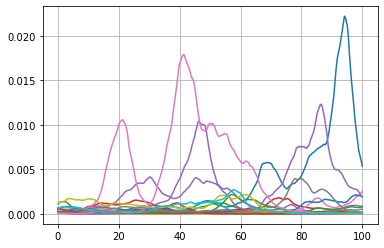

RUN  0 , total integrated cost =  30.14961740173167
Gradient descend method:  None
RUN  1 , total integrated cost =  30.146819914396396
RUN  2 , total integrated cost =  30.137785437273646
RUN  3 , total integrated cost =  10.643701729891447
RUN  4 , total integrated cost =  8.111817629176981
RUN  5 , total integrated cost =  6.515782348958078
RUN  6 , total integrated cost =  5.991432998224771
RUN  7 , total integrated cost =  6.358183646178492
RUN  8 , total integrated cost =  5.456119930403878
RUN  9 , total integrated cost =  5.558250305642152
RUN  10 , total integrated cost =  5.918124399296778
RUN  10 , total integrated cost mean =  5.918124399296778
Improved over  10  iterations in  13.336551685999439  seconds by  80.37081426128856  percent.


In [36]:
aln.params.duration = dur
zero_init = aln.getZeroControl()

mean_cost[1] = []
cost.setParams(w_p[i], w_e, w_s)

##### zero control as input for uncontrolled cost
setinit(initVars[i], aln)

bestControl[i], bestState[i], cost_[i], runtime[i], grad[i], phi[i], costnode[i], total_cost_mean_std = aln.A1(
    zero_init, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it,
    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
    control_variables_ = [0,1], prec_variables_ = [0], transition_time_ = trans_time,
    noise_real=noise_realizations, init_params = initVars[i], method='M2')
    
control_list[1] = bestControl[i]
cost_list[1] = cost_[i]

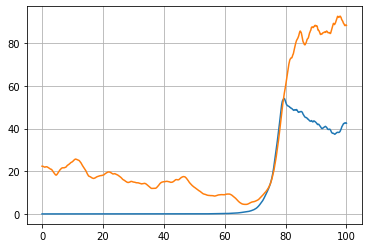

In [37]:
aln.params.duration = dur
setinit(initVars[i], aln)
aln.run(control=bestControl[i][:,:,100:-100])
plt.plot(aln.t, aln.rates_exc[0,:])
plt.plot(aln.t, aln.rates_inh[0,:])
plt.show()

In [38]:
aln.params.duration = dur
init_control = aln.getZeroControl()           
init_control[:,:,:] = control_list[1][:,:,100:-100]

cost_final = np.zeros(( noise_realizations_final ))

for n_ in range(noise_realizations_final):

    setinit(initVars[i], aln)
    state_ = fo.updateState(aln, init_control)
    cost_final[n_] += cost.numba_cost_precision_int(1,T,dt,w_p[i],state_, target_, list(prec_vars) )
    cost_final[n_] += cost.numba_cost_sparsity_int(1, 6, T, w_s, dt, init_control)

mean_cost[1].append(np.mean(cost_final))
print('mean = ', mean_cost[1])

mean =  [18.432750466287352]


--------------------------------------------------------- 0
interpolate adjoint :  True True True


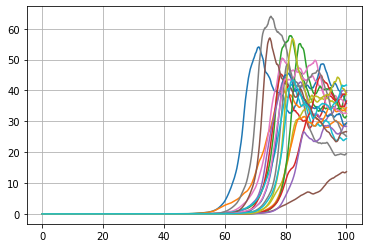

RUN  0 , total integrated cost =  17.001111693073618
Gradient descend method:  None
RUN  1 , total integrated cost =  7.334185832596598
RUN  2 , total integrated cost =  6.940727133484698
RUN  3 , total integrated cost =  6.371721018305143
RUN  4 , total integrated cost =  6.127963123884572
RUN  5 , total integrated cost =  6.072644102077571
RUN  6 , total integrated cost =  6.012458371762413
RUN  7 , total integrated cost =  6.072608714314442
RUN  8 , total integrated cost =  5.876831785413737
RUN  9 , total integrated cost =  5.648827284714451
RUN  10 , total integrated cost =  5.787372050528873
RUN  10 , total integrated cost mean =  5.787372050528873
Improved over  10  iterations in  11.187082174999887  seconds by  65.95886107326328  percent.
--------------------------------------------------------- 1
interpolate adjoint :  True True True


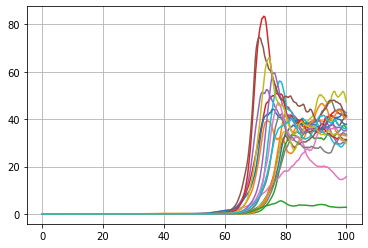

RUN  0 , total integrated cost =  9.660096850805697
Gradient descend method:  None
RUN  1 , total integrated cost =  5.902926953441159
RUN  2 , total integrated cost =  5.98958515459954
RUN  3 , total integrated cost =  5.583411840167039
RUN  4 , total integrated cost =  5.7680990684212805
RUN  5 , total integrated cost =  5.752151669872339
RUN  6 , total integrated cost =  5.690452811055453
RUN  7 , total integrated cost =  5.572708835409241
RUN  8 , total integrated cost =  5.564662801047447
RUN  9 , total integrated cost =  5.48228317108226
RUN  10 , total integrated cost =  5.995439172594287
RUN  10 , total integrated cost mean =  5.995439172594287
Improved over  10  iterations in  11.934071978999782  seconds by  37.93603454302594  percent.
--------------------------------------------------------- 2
interpolate adjoint :  True True True


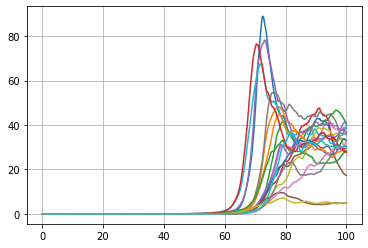

RUN  0 , total integrated cost =  10.72443969694003
Gradient descend method:  None
RUN  1 , total integrated cost =  5.912440321354781
RUN  2 , total integrated cost =  5.644648978072227
RUN  3 , total integrated cost =  5.527619088356671
RUN  4 , total integrated cost =  5.554733644610647
RUN  5 , total integrated cost =  5.569561003553112
RUN  6 , total integrated cost =  5.673421603663121
RUN  7 , total integrated cost =  5.509736434030202
RUN  8 , total integrated cost =  5.790586703126857
no cost improvement
RUN  9 , total integrated cost =  5.5623044803803925
RUN  10 , total integrated cost =  5.535312196509817
RUN  10 , total integrated cost mean =  5.535312196509817
Improved over  10  iterations in  13.649051067000983  seconds by  48.386001013281934  percent.
--------------------------------------------------------- 3
interpolate adjoint :  True True True


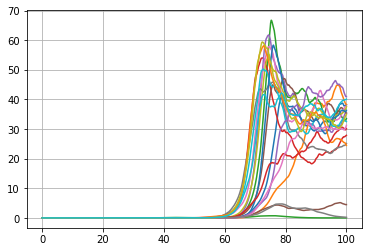

RUN  0 , total integrated cost =  18.666447724457015
Gradient descend method:  None
RUN  1 , total integrated cost =  5.624172009358107
RUN  2 , total integrated cost =  5.279549670823897
RUN  3 , total integrated cost =  5.339110860544933
RUN  4 , total integrated cost =  5.7328230579853265
RUN  5 , total integrated cost =  5.4907711018536585
RUN  6 , total integrated cost =  5.659892273977325
no cost improvement
RUN  7 , total integrated cost =  5.624500914938617
RUN  8 , total integrated cost =  5.710339289854499
RUN  9 , total integrated cost =  5.990200740871601
RUN  10 , total integrated cost =  5.5130759088619525
RUN  10 , total integrated cost mean =  5.5130759088619525
Improved over  10  iterations in  12.646220863998678  seconds by  70.46531836028635  percent.
--------------------------------------------------------- 4
interpolate adjoint :  True True True


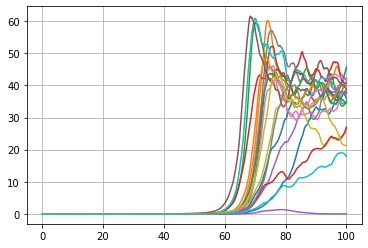

RUN  0 , total integrated cost =  13.066977467274313
Gradient descend method:  None
RUN  1 , total integrated cost =  5.4526971141661615
RUN  2 , total integrated cost =  5.557045879398362
RUN  3 , total integrated cost =  5.723089075301727
RUN  4 , total integrated cost =  5.5616845197663904
RUN  5 , total integrated cost =  5.6756995854227394
no cost improvement
RUN  6 , total integrated cost =  5.498404586414161
RUN  7 , total integrated cost =  5.396991957381941
RUN  7 , total integrated cost mean =  5.396991957381941
Improved over  7  iterations in  8.51588146299946  seconds by  58.69747253411528  percent.
--------------------------------------------------------- 5
interpolate adjoint :  True True True


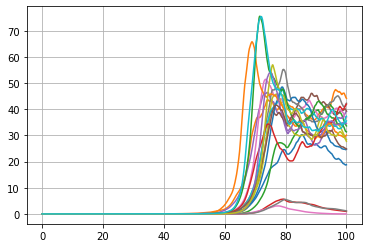

RUN  0 , total integrated cost =  15.841009781419157
Gradient descend method:  None
RUN  1 , total integrated cost =  5.47527295201358
RUN  2 , total integrated cost =  5.5485764417225125
RUN  3 , total integrated cost =  5.498356965365971
RUN  4 , total integrated cost =  5.498963514786105
RUN  5 , total integrated cost =  5.512863201618915
RUN  6 , total integrated cost =  5.478280638450072
RUN  7 , total integrated cost =  5.70898718325874
no cost improvement
RUN  8 , total integrated cost =  5.61668220266773
RUN  9 , total integrated cost =  5.521732715750042
RUN  10 , total integrated cost =  5.440737500883342
RUN  10 , total integrated cost mean =  5.440737500883342
Improved over  10  iterations in  13.012635316999877  seconds by  65.65409922753093  percent.
--------------------------------------------------------- 6
interpolate adjoint :  True True True


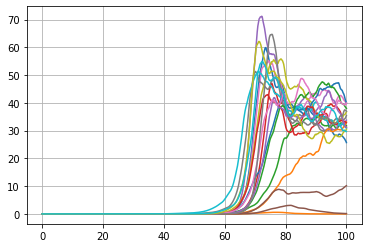

RUN  0 , total integrated cost =  18.183707462796143
Gradient descend method:  None
RUN  1 , total integrated cost =  5.419229806088728
RUN  2 , total integrated cost =  5.4851817754788454
RUN  3 , total integrated cost =  5.7542076661340165
RUN  4 , total integrated cost =  5.430387131340593
RUN  5 , total integrated cost =  5.430580911621678
RUN  6 , total integrated cost =  5.5556258173270425
RUN  7 , total integrated cost =  5.950591576336097
no cost improvement
RUN  8 , total integrated cost =  5.611476956816207
RUN  9 , total integrated cost =  5.270954877206165
RUN  9 , total integrated cost mean =  5.270954877206165
Improved over  9  iterations in  10.928323273999922  seconds by  71.0127602526023  percent.
--------------------------------------------------------- 7
interpolate adjoint :  True True True


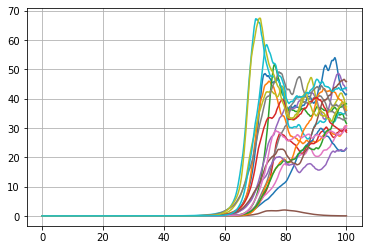

RUN  0 , total integrated cost =  11.80445780822156
Gradient descend method:  None
RUN  1 , total integrated cost =  5.755960069298067
RUN  2 , total integrated cost =  5.661616286789387
RUN  3 , total integrated cost =  5.634683010576085
RUN  4 , total integrated cost =  5.538028122094783
RUN  5 , total integrated cost =  5.502004824591014
RUN  6 , total integrated cost =  5.411466748415999
RUN  7 , total integrated cost =  5.371103492825169
RUN  8 , total integrated cost =  5.615684391425584
RUN  9 , total integrated cost =  5.581008003296587
RUN  10 , total integrated cost =  5.693857580597442
no cost improvement
RUN  10 , total integrated cost mean =  5.693857580597442
Improved over  10  iterations in  12.938411618000828  seconds by  51.76519181904494  percent.
--------------------------------------------------------- 8
interpolate adjoint :  True True True


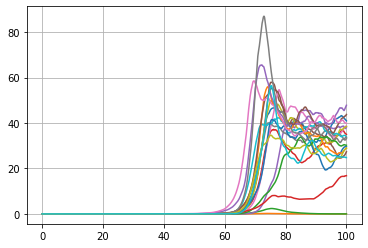

RUN  0 , total integrated cost =  20.15100707273474
Gradient descend method:  None
RUN  1 , total integrated cost =  5.447204380959138
RUN  2 , total integrated cost =  5.655202665886296
RUN  3 , total integrated cost =  5.623905524571515
RUN  4 , total integrated cost =  5.664468508620105
RUN  5 , total integrated cost =  5.67027242319327
no cost improvement
RUN  6 , total integrated cost =  5.627824443147145
RUN  7 , total integrated cost =  5.846315734831346
RUN  8 , total integrated cost =  5.614098016404116
RUN  9 , total integrated cost =  5.474319042276394
RUN  9 , total integrated cost mean =  5.474319042276394
Improved over  9  iterations in  10.868242886001099  seconds by  72.83352130979397  percent.
--------------------------------------------------------- 9
interpolate adjoint :  True True True


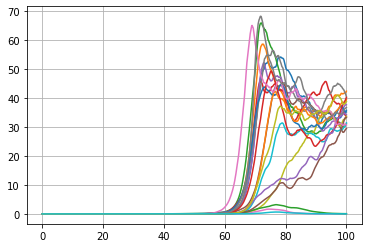

RUN  0 , total integrated cost =  23.11037316696523
Gradient descend method:  None
RUN  1 , total integrated cost =  5.377884630735489
RUN  2 , total integrated cost =  5.456167052758059
RUN  3 , total integrated cost =  5.594006287630952
RUN  4 , total integrated cost =  5.442251595120469
RUN  5 , total integrated cost =  5.324118934139055
RUN  6 , total integrated cost =  5.316157757513816
RUN  7 , total integrated cost =  5.442283190104607
RUN  8 , total integrated cost =  5.551738847763738
RUN  9 , total integrated cost =  5.558431274576941
no cost improvement
RUN  10 , total integrated cost =  5.442455462675213
RUN  10 , total integrated cost mean =  5.442455462675213
Improved over  10  iterations in  12.045247807998749  seconds by  76.45016191060537  percent.
--------------------------------------------------------- 10
interpolate adjoint :  True True True


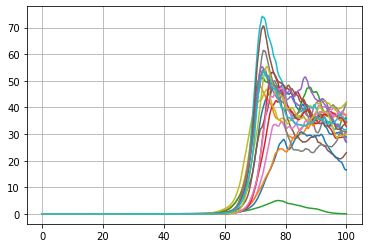

RUN  0 , total integrated cost =  9.070491498866321
Gradient descend method:  None
RUN  1 , total integrated cost =  5.366039044298146
RUN  2 , total integrated cost =  5.388916144984355
RUN  3 , total integrated cost =  5.648509864864191
RUN  4 , total integrated cost =  5.292405890378625
RUN  5 , total integrated cost =  5.417444015292562
RUN  6 , total integrated cost =  5.315785455924577
RUN  7 , total integrated cost =  5.506084554332065
RUN  8 , total integrated cost =  5.47843017246403
no cost improvement
RUN  9 , total integrated cost =  5.419352023942375
RUN  10 , total integrated cost =  5.737374697184077
RUN  10 , total integrated cost mean =  5.737374697184077
Improved over  10  iterations in  15.140574541001115  seconds by  36.74681578279232  percent.
--------------------------------------------------------- 11
interpolate adjoint :  True True True


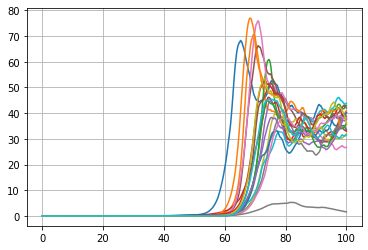

RUN  0 , total integrated cost =  8.434133407337942
Gradient descend method:  None
RUN  1 , total integrated cost =  5.535719105733396
RUN  2 , total integrated cost =  5.390924098303971
RUN  3 , total integrated cost =  5.4766454258767014
RUN  4 , total integrated cost =  5.421283784530995
RUN  5 , total integrated cost =  5.4847546089518495
RUN  6 , total integrated cost =  5.402028841934179
RUN  7 , total integrated cost =  5.335982024899762
RUN  8 , total integrated cost =  5.25502750710441
RUN  9 , total integrated cost =  5.561444679590666
RUN  10 , total integrated cost =  5.455340012572206
RUN  10 , total integrated cost mean =  5.455340012572206
Improved over  10  iterations in  15.872917199001677  seconds by  35.318310144040396  percent.
--------------------------------------------------------- 12
interpolate adjoint :  True True True


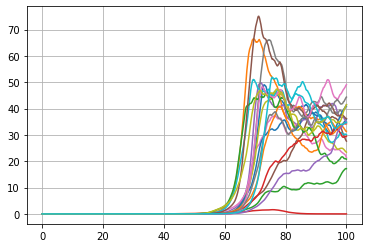

RUN  0 , total integrated cost =  13.312879209732035
Gradient descend method:  None
RUN  1 , total integrated cost =  5.575515672346735
RUN  2 , total integrated cost =  5.4455374393462055
RUN  3 , total integrated cost =  5.312573267501844
RUN  4 , total integrated cost =  5.604073887514934
RUN  5 , total integrated cost =  5.47050540792279
RUN  6 , total integrated cost =  5.419100269547617
RUN  7 , total integrated cost =  5.588652438373815
no cost improvement
RUN  8 , total integrated cost =  5.584568815144689
RUN  9 , total integrated cost =  5.670417189866528
RUN  10 , total integrated cost =  5.632291065799968
RUN  10 , total integrated cost mean =  5.632291065799968
Improved over  10  iterations in  15.597136705000594  seconds by  57.69291543122672  percent.
--------------------------------------------------------- 13
interpolate adjoint :  True True True


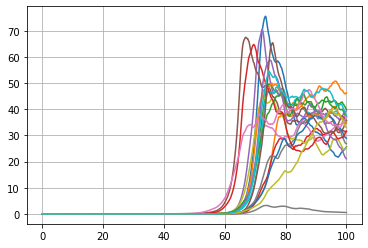

RUN  0 , total integrated cost =  9.957703105971282
Gradient descend method:  None
RUN  1 , total integrated cost =  5.3365508332848695
RUN  2 , total integrated cost =  5.381648598740837
RUN  3 , total integrated cost =  5.511766656120026
RUN  4 , total integrated cost =  5.307116934109621
RUN  5 , total integrated cost =  5.320418651672061
RUN  6 , total integrated cost =  5.546810784684373
RUN  7 , total integrated cost =  5.700063259292018
no cost improvement
RUN  8 , total integrated cost =  5.810084173861106
RUN  9 , total integrated cost =  5.614895548378732
RUN  10 , total integrated cost =  5.673385223945407
RUN  10 , total integrated cost mean =  5.673385223945407
Improved over  10  iterations in  11.091443637998964  seconds by  43.02516189156837  percent.
--------------------------------------------------------- 14
interpolate adjoint :  True True True


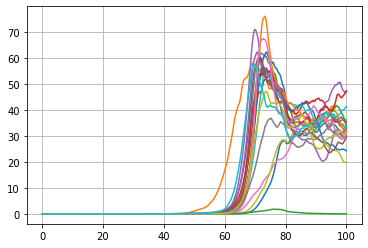

RUN  0 , total integrated cost =  11.579622499352983
Gradient descend method:  None
RUN  1 , total integrated cost =  5.565448254401284
RUN  2 , total integrated cost =  5.328347750046234
RUN  3 , total integrated cost =  5.466704620660123
RUN  4 , total integrated cost =  5.412755489622155
RUN  5 , total integrated cost =  5.599018844423728
no cost improvement
RUN  6 , total integrated cost =  5.626159575658763
RUN  7 , total integrated cost =  5.362762062730942
RUN  8 , total integrated cost =  5.474614038763814
RUN  8 , total integrated cost mean =  5.474614038763814
Improved over  8  iterations in  13.431501666000258  seconds by  52.721999019659656  percent.
--------------------------------------------------------- 15
interpolate adjoint :  True True True


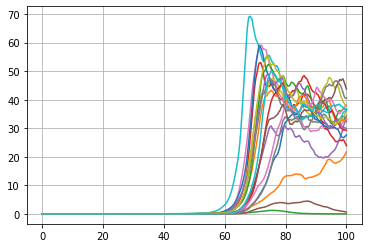

RUN  0 , total integrated cost =  14.6133304167174
Gradient descend method:  None
RUN  1 , total integrated cost =  5.671324872749955
RUN  2 , total integrated cost =  5.53692543745139
RUN  3 , total integrated cost =  5.348030341118909
RUN  4 , total integrated cost =  5.34028911575929
RUN  5 , total integrated cost =  5.392020450363015
RUN  6 , total integrated cost =  5.41011153729225
RUN  7 , total integrated cost =  5.533817808773001
RUN  8 , total integrated cost =  5.374926561649998
RUN  9 , total integrated cost =  5.547574235860699
RUN  10 , total integrated cost =  5.346067762541294
RUN  10 , total integrated cost mean =  5.346067762541294
Improved over  10  iterations in  13.50272172699988  seconds by  63.416499797845646  percent.
--------------------------------------------------------- 16
interpolate adjoint :  True True True


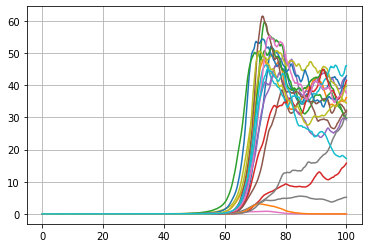

RUN  0 , total integrated cost =  21.92205074565672
Gradient descend method:  None
RUN  1 , total integrated cost =  5.462336486340621
RUN  2 , total integrated cost =  5.47553254179053
RUN  3 , total integrated cost =  5.299682542231717
RUN  4 , total integrated cost =  5.368885925972473
RUN  5 , total integrated cost =  5.787609975545572
no cost improvement
RUN  6 , total integrated cost =  5.718075150908457
RUN  7 , total integrated cost =  5.559549323770076
RUN  8 , total integrated cost =  5.48395405940921
RUN  9 , total integrated cost =  5.513001324613997
RUN  9 , total integrated cost mean =  5.513001324613997
Improved over  9  iterations in  23.286187149999023  seconds by  74.85179927472683  percent.
--------------------------------------------------------- 17
interpolate adjoint :  True True True


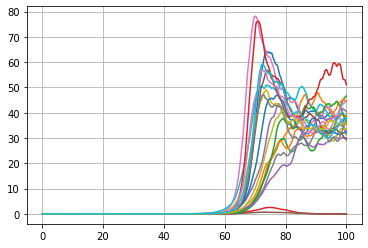

RUN  0 , total integrated cost =  17.39665784109363
Gradient descend method:  None
RUN  1 , total integrated cost =  5.399351237373802
RUN  2 , total integrated cost =  5.639075467610673
RUN  3 , total integrated cost =  5.344443922395921
RUN  4 , total integrated cost =  5.458365886328706
RUN  5 , total integrated cost =  5.629115125029693
RUN  6 , total integrated cost =  5.411006761145109
RUN  7 , total integrated cost =  5.473045251332551
RUN  8 , total integrated cost =  5.43217714321847
RUN  9 , total integrated cost =  5.504196779462449
RUN  10 , total integrated cost =  5.756808664233668
no cost improvement
RUN  10 , total integrated cost mean =  5.756808664233668
Improved over  10  iterations in  22.152977369998553  seconds by  66.90853658893501  percent.
--------------------------------------------------------- 18
interpolate adjoint :  True True True


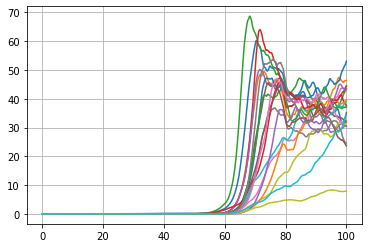

RUN  0 , total integrated cost =  8.881306776937869
Gradient descend method:  None
RUN  1 , total integrated cost =  5.457945269962117
RUN  2 , total integrated cost =  5.424558281960527
RUN  3 , total integrated cost =  5.398301598315936
RUN  4 , total integrated cost =  5.613490148841064
RUN  5 , total integrated cost =  5.654354856443243
no cost improvement
RUN  6 , total integrated cost =  5.505081163652341
RUN  7 , total integrated cost =  5.569699148208903
RUN  8 , total integrated cost =  5.51774658768472
RUN  9 , total integrated cost =  5.772674743681453
RUN  10 , total integrated cost =  5.69548009846668
RUN  10 , total integrated cost mean =  5.69548009846668
Improved over  10  iterations in  24.146866060998946  seconds by  35.87114777685464  percent.
mean =  [18.432750466287352, 8.916714438805583, 10.368475491780043, 13.017816404765368, 11.324356053326108, 14.072821651209434, 13.094943119084913, 15.056280910397508, 11.492783810091344, 15.765319554178477, 13.098840817259095,

In [39]:
for k_ in range(19):
    print('---------------------------------------------------------', k_)
    setinit(initVars[i], aln)
    
    init_control = aln.getZeroControl()           
    init_control[:,:,:] = control_list[1][:,:,100:-100]

    bestControl[i], bestState[i], cost_[i], runtime[i], grad[i], phi[i], costnode[i], total_cost_mean_std = aln.A1(
        init_control, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it,
        tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
        t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
        control_variables_ = [0,1], prec_variables_ = prec_vars, transition_time_ = trans_time,
        noise_real=noise_realizations, init_params = initVars[i], method='M2')

    control_list[1] = bestControl[i]

    aln.params.duration = dur
    init_control = aln.getZeroControl()           
    init_control[:,:,:] = control_list[1][:,:,100:-100]

    cost_final = np.zeros(( noise_realizations_final ))

    for n_ in range(noise_realizations_final):

        setinit(initVars[i], aln)
        state_ = fo.updateState(aln, init_control)
        cost_final[n_] += cost.numba_cost_precision_int(1,T,dt,w_p[i],state_, target_, list(prec_vars) )
        cost_final[n_] += cost.numba_cost_sparsity_int(1, 6, T, w_s, dt, init_control)

    mean_cost[1].append(np.mean(cost_final))

print('mean = ', mean_cost[1])

In [40]:
aln.params.duration = dur
zero_init = aln.getZeroControl()

##### zero control as input for uncontrolled cost
setinit(initVars[i], aln)
mean_cost[2] = []

bestControl[i], bestState[i], cost_[i], runtime[i], grad[i], phi[i], costnode[i], total_cost_mean_std = aln.A1(
    zero_init, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it,
    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
    control_variables_ = [0,1], prec_variables_ = [0], transition_time_ = trans_time,
    noise_real=noise_realizations, init_params = initVars[i], method='M3')
    
control_list[2] = bestControl[i]
cost_list[2] = cost_[i]

interpolate adjoint :  True True True
RUN  0 , total integrated cost =  30.15073625148281
Gradient descend method:  None
RUN  1 , total integrated cost =  30.15087045274608
RUN  2 , total integrated cost =  30.150304296437003
RUN  3 , total integrated cost =  30.151213221574107
RUN  4 , total integrated cost =  10.200813509433305
RUN  5 , total integrated cost =  6.122510453625407
RUN  6 , total integrated cost =  6.612979849008681
RUN  7 , total integrated cost =  6.199175372556789
RUN  8 , total integrated cost =  5.91393965372375
RUN  9 , total integrated cost =  5.88725799121527
RUN  10 , total integrated cost =  6.346155668813783
RUN  10 , total integrated cost mean =  6.346155668813783
Improved over  10  iterations in  16.159251093999046  seconds by  78.95190480298245  percent.


In [41]:
aln.params.duration = dur
init_control = aln.getZeroControl()           
init_control[:,:,:] = control_list[2][:,:,100:-100]

cost_final = np.zeros(( noise_realizations_final ))

for n_ in range(noise_realizations_final):

    setinit(initVars[i], aln)
    state_ = fo.updateState(aln, init_control)
    cost_final[n_] += cost.numba_cost_precision_int(1,T,dt,w_p[i],state_, target_, list(prec_vars) )
    cost_final[n_] += cost.numba_cost_sparsity_int(1, 6, T, w_s, dt, init_control)

mean_cost[2].append(np.mean(cost_final))
print('mean = ', mean_cost[2])

mean =  [10.228780589594992]


In [42]:
for k_ in range(19):
    print('---------------------------------------------------------', k_)
    setinit(initVars[i], aln)
    
    init_control = aln.getZeroControl()           
    init_control[:,:,:] = control_list[2][:,:,100:-100]

    bestControl[i], bestState[i], cost_[i], runtime[i], grad[i], phi[i], costnode[i], total_cost_mean_std = aln.A1(
        init_control, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it,
        tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
        t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
        control_variables_ = [0,1], prec_variables_ = prec_vars, transition_time_ = trans_time,
        noise_real=noise_realizations, init_params = initVars[i], method='M3')

    control_list[2] = bestControl[i]

    aln.params.duration = dur
    init_control = aln.getZeroControl()           
    init_control[:,:,:] = control_list[2][:,:,100:-100]

    cost_final = np.zeros(( noise_realizations_final ))

    for n_ in range(noise_realizations_final):

        setinit(initVars[i], aln)
        state_ = fo.updateState(aln, init_control)
        cost_final[n_] += cost.numba_cost_precision_int(1,T,dt,w_p[i],state_, target_, list(prec_vars) )
        cost_final[n_] += cost.numba_cost_sparsity_int(1, 6, T, w_s, dt, init_control)

    mean_cost[2].append(np.mean(cost_final))

print('mean = ', mean_cost[2])

--------------------------------------------------------- 0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9.45388366089165
Gradient descend method:  None
RUN  1 , total integrated cost =  5.894507489665341
RUN  2 , total integrated cost =  6.346275152560457
RUN  3 , total integrated cost =  6.7395712597171125
RUN  4 , total integrated cost =  6.731935279040708
RUN  5 , total integrated cost =  5.884645587328321
RUN  6 , total integrated cost =  5.862825539661745
RUN  7 , total integrated cost =  5.727892674555854
RUN  8 , total integrated cost =  6.612404093869003
RUN  9 , total integrated cost =  5.945537304034428
RUN  10 , total integrated cost =  6.3393859549312745
RUN  10 , total integrated cost mean =  6.3393859549312745
Improved over  10  iterations in  17.971913843999573  seconds by  32.94410866133536  percent.
--------------------------------------------------------- 1
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  6.2099612489

RUN  1 , total integrated cost =  6.073035735530929
RUN  2 , total integrated cost =  6.438597973274723
RUN  3 , total integrated cost =  6.69719215322929
RUN  4 , total integrated cost =  6.601065846473375
RUN  5 , total integrated cost =  6.262982650716561
RUN  6 , total integrated cost =  5.919335056401751
RUN  7 , total integrated cost =  6.999815683372953
RUN  8 , total integrated cost =  6.525356006922993
no cost improvement
RUN  9 , total integrated cost =  5.84671012265353
RUN  9 , total integrated cost mean =  5.84671012265353
Improved over  9  iterations in  21.7181088740017  seconds by  10.743394998741863  percent.
--------------------------------------------------------- 11
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9.076631296823209
Gradient descend method:  None
RUN  1 , total integrated cost =  5.912393512520184
RUN  2 , total integrated cost =  11.865390512346542
RUN  3 , total integrated cost =  5.863036716914888
RUN  4 , total integrated c

In [43]:
aln.params.duration = dur
zero_init = aln.getZeroControl()

mean_cost[3] = []

##### zero control as input for uncontrolled cost
setinit(initVars[i], aln)

bestControl[i], bestState[i], cost_[i], runtime[i], grad[i], phi[i], costnode[i], total_cost_mean_std = aln.A1(
    zero_init, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it,
    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
    control_variables_ = [0,1], prec_variables_ = [0], transition_time_ = trans_time,
    noise_real=noise_realizations, init_params = initVars[i], method='M4')

control_list[3] = bestControl[i]
cost_list[3] = cost_[i]

interpolate adjoint :  True True True
RUN  0 , total integrated cost =  30.14953083704312
Gradient descend method:  None
RUN  1 , total integrated cost =  30.15109926274858
RUN  2 , total integrated cost =  30.15020139910623
RUN  3 , total integrated cost =  11.622968616445815
RUN  4 , total integrated cost =  8.301795589555521
RUN  5 , total integrated cost =  7.11179407191049
RUN  6 , total integrated cost =  7.100727873219566
RUN  7 , total integrated cost =  8.177375857246865
RUN  8 , total integrated cost =  7.523745133726112
RUN  9 , total integrated cost =  7.331517311969188
RUN  10 , total integrated cost =  7.3461691943076515
RUN  10 , total integrated cost mean =  7.3461691943076515
Improved over  10  iterations in  16.752095599000313  seconds by  75.63421721547385  percent.


In [44]:
aln.params.duration = dur
init_control = aln.getZeroControl()           
init_control[:,:,:] = control_list[3][:,:,100:-100]

cost_final = np.zeros(( noise_realizations_final ))

for n_ in range(noise_realizations_final):

    setinit(initVars[i], aln)
    state_ = fo.updateState(aln, init_control)
    cost_final[n_] += cost.numba_cost_precision_int(1,T,dt,w_p[i],state_, target_, list(prec_vars) )
    cost_final[n_] += cost.numba_cost_sparsity_int(1, 6, T, w_s, dt, init_control)

mean_cost[3].append(np.mean(cost_final))
print('mean = ', mean_cost[3])

mean =  [24.764961944515488]


In [45]:
for k_ in range(19):
    print('---------------------------------------------------------', k_)
    setinit(initVars[i], aln)
    
    init_control = aln.getZeroControl()           
    init_control[:,:,:] = control_list[3][:,:,100:-100]

    bestControl[i], bestState[i], cost_[i], runtime[i], grad[i], phi[i], costnode[i], total_cost_mean_std = aln.A1(
        init_control, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it,
        tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
        t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
        control_variables_ = [0,1], prec_variables_ = prec_vars, transition_time_ = trans_time,
        noise_real=noise_realizations, init_params = initVars[i], method='M4')

    control_list[3] = bestControl[i]

    aln.params.duration = dur
    init_control = aln.getZeroControl()           
    init_control[:,:,:] = control_list[3][:,:,100:-100]

    cost_final = np.zeros(( noise_realizations_final ))

    for n_ in range(noise_realizations_final):

        setinit(initVars[i], aln)
        state_ = fo.updateState(aln, init_control)
        cost_final[n_] += cost.numba_cost_precision_int(1,T,dt,w_p[i],state_, target_, list(prec_vars) )
        cost_final[n_] += cost.numba_cost_sparsity_int(1, 6, T, w_s, dt, init_control)

    mean_cost[3].append(np.mean(cost_final))

print('mean = ', mean_cost[3])

--------------------------------------------------------- 0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  26.161798206838643
Gradient descend method:  None
RUN  1 , total integrated cost =  8.87613008855402
RUN  2 , total integrated cost =  7.416811073701962
RUN  3 , total integrated cost =  6.800550559366132
RUN  4 , total integrated cost =  6.997672505423064
RUN  5 , total integrated cost =  6.466974468254156
RUN  6 , total integrated cost =  9.309877208829018
RUN  7 , total integrated cost =  9.458937528627862
no cost improvement
RUN  8 , total integrated cost =  10.752663839220912
RUN  9 , total integrated cost =  6.920157764914289
RUN  10 , total integrated cost =  9.884483296422395
RUN  10 , total integrated cost mean =  9.884483296422395
Improved over  10  iterations in  19.378625785000622  seconds by  62.21787501656285  percent.
--------------------------------------------------------- 1
interpolate adjoint :  True True True
RUN  0 , total integrated c

--------------------------------------------------------- 10
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17.627821571218373
Gradient descend method:  None
RUN  1 , total integrated cost =  11.354514354932498
RUN  2 , total integrated cost =  6.472107215655394
RUN  3 , total integrated cost =  5.893415837571459
RUN  4 , total integrated cost =  6.364913330811195
RUN  5 , total integrated cost =  11.637804835231659
RUN  6 , total integrated cost =  6.465732279634227
RUN  7 , total integrated cost =  6.4477520245236075
RUN  8 , total integrated cost =  10.886648901054917
RUN  9 , total integrated cost =  14.209587230992724
no cost improvement
RUN  10 , total integrated cost =  18.222551600988172
RUN  10 , total integrated cost mean =  18.222551600988172
Improved over  10  iterations in  16.00576629200077  seconds by  -3.373814667722968  percent.
--------------------------------------------------------- 11
interpolate adjoint :  True True True
RUN  0 , total int

------
-0.3928010935355327
-0.20171763045701213
0.016835777280242093
0.1429809759613401
0.09745734559584222
0.13715604274718884
0.13108098803941204
0.11193445194822406
-0.026120953981395058
0.2867437498085401
0.5098065578855829
0.6058472643563664
0.48475002029938624
0.3266169300454248
0.5461209573971983
0.9749762178926323
0.9725402340677755
0.9302797382616326
------
0.26963500923231243
0.5779728051365467
0.47935629304216526
0.3725341971483413
0.36667814062887166
0.2523056939837574
0.29874503339151054
0.27503765962329946
0.4226439574244382
0.28832504598013314
0.559726055939692
0.5739520296690539
0.44487338119086045
0.7129379007565346
0.5483964760775447
-0.012507881472666802
-0.4345573470783844
-0.865963243339992
------
0.08038790772292077
0.24562689903472174
0.20407714281068529
0.1905369002689143
0.1176817649800679
0.3080455294427932
0.23559316250578455
0.40826412947967605
0.3593795301008822
0.3254041381780389
0.23117868766067787
0.11627137687849597
0.5443938719887387
0.4464057242841654

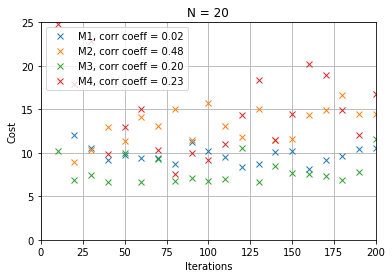

In [50]:
color = ['red', 'green', 'blue', 'orange']
l_ = ['M1', 'M2', 'M3', 'M4']

for k in range(4):
    x = np.arange(10,10*len(mean_cost[k])+1, 10)
    y = mean_cost[k]
    plt.plot( x,y, label=l_[k] + ', corr coeff = {:.2f}'.format(np.corrcoef(x[2:],y[2:])[0,1]),
             linestyle='', marker='x' )
    print('------')
    for k_ in np.arange(0,len(mean_cost[k])-2,1):
        print(np.corrcoef(x[k_:],y[k_:])[0,1])
    
plt.legend(loc='upper left')
plt.title('N = {}'.format(noise_realizations))

plt.ylim(0,25)
plt.xlim(0,200)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.savefig('method_compare_' + str(noise_realizations) + '.png')
plt.show()